In [1]:
import glob
from os import path
import string

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rc
import pandas as pd
from scipy import signal, stats
import seaborn as sns

rc("pdf", fonttype=42)

In [2]:
LIKELIHOOD_THRESH = 0.8
PEAK_THRESH = 3

In [3]:
def baseline_subtract(y):
    
    y_subtracted = -1 * (y - np.mean(y[:20]))
    
    return y_subtracted

def calc_peak_thresh(init_array:np.ndarray, zscore:float = 3):
    mean_sig = np.mean(init_array)
    std_sig = np.std(init_array)

    return mean_sig + (zscore * std_sig)

In [4]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]

    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[(window_len//2):-(window_len//2)]


In [5]:
def central_difference(t, x):
    n_samples = len(x)
    diff = np.zeros((n_samples,))
    for i in range(n_samples):
        t_i = t[i]
        x_i = x[i]
        
        if i == 0:
            next_i = i + 1
            t_next = t[next_i]
            x_next = x[next_i]
            
            diff[i] = (x_next - x_i) / t_next
        elif i == (n_samples - 1):
            prev_i = i - 1
            t_prev = t[prev_i]
            x_prev = x[prev_i]
            
            diff[i] = (x_i - x_prev) / (t_i - t_prev)
        else:
            prev_i = i - 1
            t_prev = t[prev_i]
            x_prev = x[prev_i]
            
            next_i = i + 1
            t_next = t[next_i]
            x_next = x[next_i]
            
            diff[i] = (x_next - x_prev) / (t_next - t_prev)
    
    return diff

In [6]:
csv_dir = './tapping/labeled videos and files'

prefixes_PCRt_med3_n1 = string.ascii_lowercase[0:9]
tap_PCRt_med3_n1 = {path.join(csv_dir, l + 'DeepCut_resnet50_tappingMar6shuffle1_600000.csv'): 'PCRt_med3_n1' for l in prefixes_PCRt_med3_n1}

prefixes_PCRt_med3_n3 = np.arange(1, 10)
tap_1PCRt_med3_n3 = {path.join(csv_dir, str(l) + 'DLC_resnet50_tappingMar6shuffle1_600000.csv'): 'PCRt_med3_n3' for l in prefixes_PCRt_med3_n3}

prefixes_PCRt_med3_n4 = np.arange(11, 16)
tap_PCRt_med3_n4 = {path.join(csv_dir, str(l) + 'DLC_resnet50_tappingMar6shuffle1_600000.csv'): 'PCRt_med3_n4' for l in prefixes_PCRt_med3_n4}

tapping_animals = {**tap_PCRt_med3_n1, **tap_1PCRt_med3_n3, **tap_PCRt_med3_n4}

tapping_animals

{'./tapping/labeled videos and files/aDeepCut_resnet50_tappingMar6shuffle1_600000.csv': 'PCRt_med3_n1',
 './tapping/labeled videos and files/bDeepCut_resnet50_tappingMar6shuffle1_600000.csv': 'PCRt_med3_n1',
 './tapping/labeled videos and files/cDeepCut_resnet50_tappingMar6shuffle1_600000.csv': 'PCRt_med3_n1',
 './tapping/labeled videos and files/dDeepCut_resnet50_tappingMar6shuffle1_600000.csv': 'PCRt_med3_n1',
 './tapping/labeled videos and files/eDeepCut_resnet50_tappingMar6shuffle1_600000.csv': 'PCRt_med3_n1',
 './tapping/labeled videos and files/fDeepCut_resnet50_tappingMar6shuffle1_600000.csv': 'PCRt_med3_n1',
 './tapping/labeled videos and files/gDeepCut_resnet50_tappingMar6shuffle1_600000.csv': 'PCRt_med3_n1',
 './tapping/labeled videos and files/hDeepCut_resnet50_tappingMar6shuffle1_600000.csv': 'PCRt_med3_n1',
 './tapping/labeled videos and files/iDeepCut_resnet50_tappingMar6shuffle1_600000.csv': 'PCRt_med3_n1',
 './tapping/labeled videos and files/1DLC_resnet50_tappingMar6sh

In [7]:
# get file paths
csv_dir = './tapping/labeled videos and files'
path_pattern = path.join(csv_dir, '*.csv')
files = glob.glob(path_pattern)
files.sort()

tapping_peak_max = []
tapping_speed_max = []
tapping_speed_max_smooth = []
peak_files = []
no_peak_files = []
animal_names = []

tap_y = []
tap_t = []
tap_t_norm = []
tap_y_norm = []
tap_trace_file = []
tap_trace_animal_name = []

for f in files:
    df = pd.read_csv(f, header=[1,2])

    hand_y = baseline_subtract(df['handdx']['y'].values)
    hand_likelihood = df['handdx']['likelihood'].values
    t = df.index.to_numpy()

    t_clean = t[hand_likelihood > LIKELIHOOD_THRESH]
    hand_y_clean = hand_y[hand_likelihood > LIKELIHOOD_THRESH]
    hand_y_smooth = smooth(hand_y_clean, window_len=11, window='flat')
    
    diff = central_difference(t_clean, hand_y_clean)
    diff_smooth = central_difference(t_clean, hand_y_smooth)

    ctrl = baseline_subtract(df['handsx']['y'].values)
    ctrl_likelihood = df['handsx']['likelihood'].values
    ctrl_clean = ctrl[ctrl_likelihood > LIKELIHOOD_THRESH]
    ctrl_smooth = smooth(ctrl_clean, window_len=8, window='flat')
    height_thresh = calc_peak_thresh(ctrl_smooth, zscore=PEAK_THRESH)

    # get the peak location
    smooth_peaks, smooth_props = signal.find_peaks(hand_y_smooth, height=height_thresh, distance=30)
    if len(smooth_peaks) > 0:
        max_peak_index = np.argmax(smooth_props['peak_heights'])

        search_window = np.clip([smooth_peaks[max_peak_index] - 50, smooth_peaks[max_peak_index] + 50], 0, len(hand_y_clean))
        peaks, props = signal.find_peaks(hand_y_clean[search_window[0]:search_window[1]], height=height_thresh, distance=30)
        tapping_peak_max.append(props['peak_heights'].max())
        
        peak_max_index = smooth_peaks[np.argmax(smooth_props['peak_heights'])]
        search_start = peak_max_index - 40
        speed_search_window = np.clip([search_start, peak_max_index], 0, len(diff))
        
        speed_peaks, speed_props = signal.find_peaks(diff[speed_search_window[0]:speed_search_window[1]], height=0)
        tapping_speed_max.append(speed_props['peak_heights'].max())
        
        speed_peaks_smooth, speed_props_smooth = signal.find_peaks(diff_smooth[speed_search_window[0]:speed_search_window[1]], height=0)
        tapping_speed_max_smooth.append(speed_props_smooth['peak_heights'].max())
        
        peak_files.append(f)
        animal_names.append(tapping_animals[f])
        
        # find the index where the speed crosses the threshold
        # (i.e., the onset of motion)
        initiation_index = peak_max_index
        above_thresh = True
        pos_thresh = calc_peak_thresh(hand_y_clean[:20], zscore=PEAK_THRESH)
        print(pos_thresh)
        while above_thresh:
            initiation_index -= 1
            above_thresh = (hand_y_clean[initiation_index] > pos_thresh)
            
        completion_index = peak_max_index
        above_thresh = True
        speed_thresh = calc_peak_thresh(hand_y_clean[:20], zscore=PEAK_THRESH)
        while above_thresh:
            completion_index += 1
            above_thresh = (hand_y_clean[completion_index] > pos_thresh) and hand_y_clean[completion_index] > 5

        tap_trace_y = hand_y_clean[initiation_index:completion_index] - hand_y_clean[initiation_index]
        tap_y += list(tap_trace_y)
        tap_y_norm += list(tap_trace_y / np.abs(tap_trace_y).max())              
        
        start_time = initiation_index - peak_max_index
        end_time = completion_index - peak_max_index
        tap_times = np.arange(start_time, end_time)
        tap_t += list(tap_times)
        

        tap_times_normed = tap_times / len(tap_trace_y)
        tap_t_norm += list(np.linspace(0, 1, len(tap_trace_y)))
        
        tap_trace_animal_name += len(tap_trace_y) * [tapping_animals[f]]
        tap_trace_file += len(tap_trace_y) * [f]
        
    else:
        no_peak_files.append(f)
        
tapping_df = pd.DataFrame(
    {
        'filename': peak_files,
        'distance': tapping_peak_max,
        'max_speed': tapping_speed_max,
        'max_speed_smoothed': tapping_speed_max_smooth,
        'animal_name': animal_names
    }
)

tap_traces = pd.DataFrame(
    {
        'y': tap_y,
        't': tap_t,
        't_norm': tap_t_norm,
        'y_norm': tap_y_norm,
        'file': tap_trace_file,
        'animal_name': tap_trace_animal_name
    }
)

2.2323035534483693
1.9315827399226584
2.6453516605897334
1.7196194550158588
7.77335915295939
8.733365065431693
6.214588043661178


/Users/yamauc0000/Documents/PoseProcessor/.venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/yamauc0000/Documents/PoseProcessor/.venv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/yamauc0000/Documents/PoseProcessor/.venv/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/yamauc0000/Documents/PoseProcessor/.venv/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/yamauc0000/Documents/PoseProcessor/.venv/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/yamauc0000/Documents/PoseP

7.795295028089022
2.4465017237885287
1.5840050354421897


['./tapping/labeled videos and files/14DLC_resnet50_tappingMar6shuffle1_600000.csv']


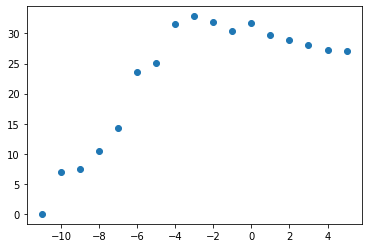

In [8]:
# delete the bad animal 1 trace

fs = ['./tapping/labeled videos and files/14DLC_resnet50_tappingMar6shuffle1_600000.csv',
 './tapping/labeled videos and files/15DLC_resnet50_tappingMar6shuffle1_600000.csv']
df = tap_traces.loc[(tap_traces['animal_name'] == 'PCRt_med3_n4') & (tap_traces['file'] == fs[0])]

plt.scatter(df['t'], df['y'])

print(df['file'].unique())

tap_traces = tap_traces.loc[tap_traces['file'] != fs[0]]

In [9]:
tap_binned_df = []

for a in ['PCRt_med3_n1','PCRt_med3_n3', 'PCRt_med3_n4']:

    df = tap_traces.loc[tap_traces['animal_name'] == a, :]

    bins = np.linspace(0, 1, 16)
    df['t_norm_bin'] = df.apply(lambda row: np.digitize(row['t_norm'], bins, right=False), axis=1)

    #df.t_norm_bin.loc[df['t'] == 0] = 0

    means = df.groupby('t_norm_bin')[['y', 'y_norm']].mean()
    stdevs = df.groupby('t_norm_bin')[['y', 'y_norm']].std()

    tap_binned_df.append(means.merge(stdevs, on='t_norm_bin', suffixes=('_mean', '_stdev')))

/Users/yamauc0000/Documents/PoseProcessor/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


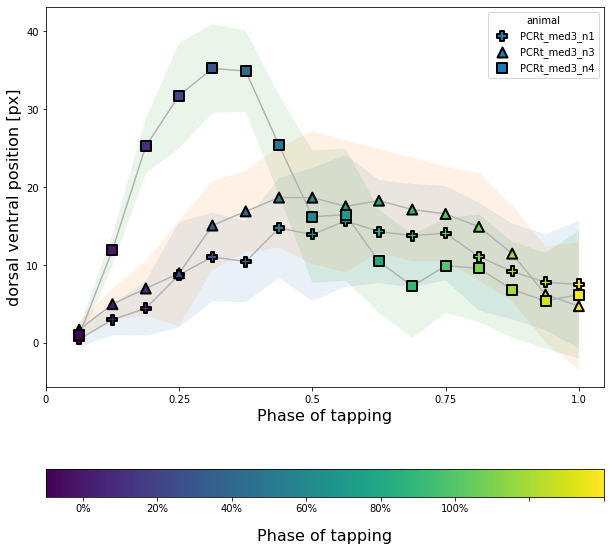

In [11]:
f, ax = plt.subplots(figsize=(10, 10))

symbols = {
    0: 'P',
    1: '^',
    2:'s'
}

for i, a in enumerate(['PCRt_med3_n1','PCRt_med3_n3', 'PCRt_med3_n4']):

    ax.fill_between(
        tap_binned_df[i].index,
        tap_binned_df[i]['y_mean'] - tap_binned_df[0]['y_stdev'],
        tap_binned_df[i]['y_mean'] + tap_binned_df[0]['y_stdev'],
        alpha=0.1,
        zorder=-32
    )

    sc = ax.scatter( 
        tap_binned_df[i].index,
        tap_binned_df[i]['y_mean'],
        c=list(tap_binned_df[i].index),
        s=100,
        linewidths=2,
        edgecolors='black',
        marker=symbols[i],
        label=a
    )

    ax.plot(
        tap_binned_df[i].index,
        tap_binned_df[i]['y_mean'],
        color=[0.7, 0.7, 0.7, 1],
        zorder=-32,

    )



plt.legend(title='animal')
cbar = plt.colorbar(sc,  orientation="horizontal")
cbar.ax.set_xticklabels([f'{t:.0f}%' for t in np.linspace(0, 100, 6)]);
cbar.set_label('Phase of tapping', fontsize=16, labelpad=15)

ax.set_xlabel('Phase of tapping', fontsize=16)
ax.set_ylabel('dorsal ventral position [px]', fontsize=16)
#ax.set_aspect('equal', 'box')

plt.xticks([0, 4, 8, 12, 16], [0, 0.25, 0.50, 0.75, 1.00])


f.savefig('tapping_trajectories_error_shaded.png', dpi=300, bbox_inches='tight')
f.savefig('tapping_trajectories_error_shaded.svg', dpi=300, bbox_inches='tight')

In [ ]:
f, ax  = plt.subplots(figsize=(5, 5))

ax = sns.regplot(x="distance", y="max_speed", data=tapping_df, ci=None, ax=ax, scatter_kws={'color': 'black'})

ax.set_xlabel('Tap distance [px]', fontsize=14)
ax.set_ylabel('Max tap speed [px / frame]', fontsize=14)

ax.set_xlim((0, 38))

r = stats.pearsonr(tapping_peak_max, tapping_speed_max)[0]

print(f'Pearson r={r:.2}')

f.savefig('tap_speed_distance_corr.png', dpi=300, bbox_inches='tight')

In [ ]:
f, ax  = plt.subplots(figsize=(5, 5))

ax = sns.barplot(y='distance', ci='sd', data=tapping_df, ax=ax, color=[0.7, 0.7, 0.7, 1])
ax = sns.stripplot(y='distance', data=tapping_df, ax=ax, size=10)

ax.set_ylabel('Tapping amplitude [px]', fontsize=14)
f.savefig('tap_amplitude.png', dpi=300, bbox_inches='tight')

In [ ]:
tapping_stdevs = tapping_df.groupby('animal_name')['distance'].std().values
tapping_means = tapping_df.groupby('animal_name')['distance'].mean().values

tapping_cvs = np.divide(tapping_stdevs, tapping_means)

print(tapping_cvs)

f, ax  = plt.subplots(figsize=(5, 5))

ax = sns.barplot(x='animal_name', y='distance', ci='sd', data=tapping_df, ax=ax, color=[0.7, 0.7, 0.7, 1])
ax = sns.stripplot(x='animal_name', y='distance', data=tapping_df, ax=ax, size=10)

ax.set_xlabel('Animal name', fontsize=14)
ax.set_ylabel('Tapping amplitude [px]', fontsize=14)
f.savefig('tap_amplitude_stratified_by_animal.png', dpi=300, bbox_inches='tight')

In [ ]:
std_peak_max = np.nanstd(tapping_peak_max)
mean_peak_max = np.nanmean(tapping_peak_max)

print(std_peak_max / mean_peak_max)
print(len(tapping_peak_max))



# Reaching

In [206]:
# get file paths
csv_dir = './SPreaching/'
path_pattern = path.join(csv_dir, '*.csv')
reaching_files = glob.glob(path_pattern)
reaching_files.sort()


In [207]:
prefixes_13_1 = string.ascii_lowercase[0:9]
reaching_13_1 = {path.join(csv_dir, l + 'DeepCut_resnet50_SPNreachingSep9shuffle1_500000.csv'): '13_1' for l in prefixes_13_1}

prefixes_13_2 = string.ascii_lowercase[12:22] + 'h'
reaching_13_2 = {path.join(csv_dir, l + 'DLC_resnet50_SPNreachingSep9shuffle1_500000.csv'): '13_2' for l in prefixes_13_2}

prefixes_13_3 = np.arange(1, 19)
reaching_13_3 = {path.join(csv_dir, str(l) + 'DLC_resnet50_SPNreachingSep9shuffle1_500000.csv'): '13_3' for l in prefixes_13_3}

prefixes_13_4 = np.arange(20, 42)
reaching_13_4 = {path.join(csv_dir, str(l) + 'DLC_resnet50_SPNreachingSep9shuffle1_500000.csv'): '13_4' for l in prefixes_13_4}

reaching_animals = {**reaching_13_1, **reaching_13_2, **reaching_13_3, **reaching_13_4}

In [208]:
f = reaching_files[0]
df = pd.read_csv(f, header=[1,2])

df.head()

bodyparts        Hand                            Finger1              \
     coords           x           y likelihood           x           y   
0         0  401.650940  387.278534        1.0  407.644958  397.113342   
1         1  402.179657  387.619232        1.0  405.410065  396.193604   
2         2  402.210663  387.368164        1.0  405.381409  396.407043   
3         3  401.670929  386.924286        1.0  404.593384  396.236969   
4         4  401.086365  387.476990        1.0  404.122498  396.403473   

                 Finger2                            Finger3              \
  likelihood           x           y likelihood           x           y   
0        1.0  434.590515  404.586456        1.0  442.223267  414.213043   
1        1.0  434.707458  404.719757        1.0  442.346039  414.532074   
2        1.0  434.600067  404.335938        1.0  442.321228  414.456329   
3        1.0  434.315247  404.318848        1.0  442.111633  414.485016   
4        1.0  434.278931  404.293549        1.0  441.994324  414.328857   

                 Finger4                         
  likelihood           x           y likelihood  
0   0.999999  542.670837  258.373016   0.010354  
1   0.999999  543.055237  258.351929   0.015236  
2   0.999999  437.061218  393.519318   0.021494  
3   0.999999  436.815002  393.246887   0.021843  
4   0.999999  436.508484  393.700623   0.043850

/Users/yamauc0000/Documents/PoseProcessor/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/yamauc0000/Documents/PoseProcessor/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in true_divide


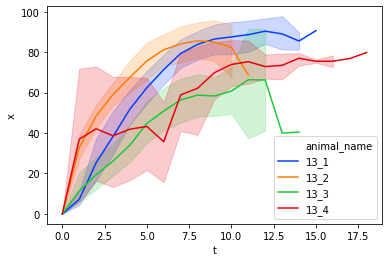

In [209]:
reaching_peak_max = []
reaching_speed_max = []
reaching_speed_max_smooth = []
peak_files = []
no_peak_files = []
animal_names = []
initiation_indices = []
end_point_indices = []

end_point_x = []
end_point_y = []

reach_x = []
reach_y = []
reach_t = []
reach_t_norm = []
reach_x_norm = []
reach_y_norm = []
reach_trace_animal_name = []
reach_trace_file = []

speed_times = []
speed_profiles = []
speed_animal_names = []

for i, f in enumerate(reaching_files):
    df = pd.read_csv(f, header=[1,2])

    hand_x = -1 * baseline_subtract(df['Hand']['x'].values)
    hand_y = baseline_subtract(df['Hand']['y'].values)
    hand_likelihood = df['Hand']['likelihood'].values
    t = df.index.to_numpy()

    t_clean = t[hand_likelihood > LIKELIHOOD_THRESH]
    hand_x_clean = hand_x[hand_likelihood > LIKELIHOOD_THRESH]
    hand_y_clean = hand_y[hand_likelihood > LIKELIHOOD_THRESH]
    hand_x_smooth = smooth(hand_x_clean, window_len=11, window='flat')
    
    diff = central_difference(t_clean, hand_x_clean)
    diff_smooth = central_difference(t_clean, hand_x_smooth)

    # ctrl = baseline_subtract(df['handsx']['x'].values)
    # ctrl_likelihood = df['handsx']['likelihood'].values
    # ctrl_clean = ctrl[ctrl_likelihood > LIKELIHOOD_THRESH]
    # ctrl_smooth = smooth(ctrl_clean, window_len=8, window='flat')
    height_thresh = calc_peak_thresh(hand_x_smooth[:20], zscore=PEAK_THRESH)

    # get the peak location
    smooth_peaks, smooth_props = signal.find_peaks(hand_x_smooth, height=height_thresh, distance=30)

    if len(smooth_peaks) > 0:
        max_peak_index = np.argmax(smooth_props['peak_heights'])

        search_window = np.clip([smooth_peaks[max_peak_index] - 50, smooth_peaks[max_peak_index] + 50], 0, len(hand_x_clean))
        peaks, props = signal.find_peaks(hand_x_clean[search_window[0]:search_window[1]], height=height_thresh, distance=30)
        reaching_peak_max.append(props['peak_heights'].max())
        end_point_index = search_window[0] + peaks[np.argmax(props['peak_heights'])]
        
        max_displacement_index = search_window[0] + peaks[np.argmax(props['peak_heights'])]
        end_point_x.append(hand_x_clean[max_displacement_index])
        end_point_y.append(hand_y_clean[max_displacement_index])

        peak_max_index = smooth_peaks[np.argmax(smooth_props['peak_heights'])]
        search_start = peak_max_index - 30
        speed_search_window = np.clip([search_start, peak_max_index], 0, len(diff))
        
        speed_peaks, speed_props = signal.find_peaks(diff[speed_search_window[0]:speed_search_window[1]], height=0)
        reaching_speed_max.append(speed_props['peak_heights'].max())
        speed_peak_index = speed_peaks[np.argmax(speed_props['peak_heights'])]
        
        speed_peaks_smooth, speed_props_smooth = signal.find_peaks(diff_smooth[speed_search_window[0]:speed_search_window[1]], height=0)
        reaching_speed_max_smooth.append(speed_props_smooth['peak_heights'].max())

        
        peak_files.append(f)
        animal_names.append(reaching_animals[f])
        
        # find the index where the speed crosses the threshold
        # (i.e., the onset of motion)
        initiation_index = peak_max_index
        above_thresh = True
        speed_thresh = calc_peak_thresh(diff_smooth[:20], zscore=PEAK_THRESH)
        while above_thresh:
            initiation_index -= 1
            above_thresh = (diff_smooth[initiation_index] > speed_thresh) and (hand_x_clean[initiation_index] > 5)
            
        initiation_indices.append(initiation_index)
        end_point_indices.append(end_point_index)

        reach_trace_x = hand_x_clean[initiation_index:peak_max_index] - hand_x_clean[initiation_index]
        reach_x += list(reach_trace_x)
        reach_x_norm += list(reach_trace_x / reach_trace_x.max())
        
        reach_trace_y = hand_y_clean[initiation_index:peak_max_index] - hand_y_clean[initiation_index]
        reach_y += list(reach_trace_y)
        reach_y_norm += list(reach_trace_y / np.abs(reach_trace_y).max())              
        
        reach_times = np.arange(len(reach_trace_x))
        reach_t += list(reach_times)
        
        
        reach_times_normed = reach_times / len(reach_trace_x)
        reach_t_norm += list(np.linspace(0, 1, len(reach_trace_x)))
        
        reach_trace_animal_name += len(reach_trace_x) * [reaching_animals[f]]
        reach_trace_file += len(reach_trace_x) * [f]
        
#         speed_profile_window = np.clip([speed_peak_index-50, speed_peak_index+50], 0, len(diff))
#         window_left = -1* (speed_peak_index - speed_profile_window[0])
#         window_right = speed_profile_window[1] - speed_peak_index
#         speed_time_rel = list(np.arange(window_left, window_right))
#         speed_times = speed_times + speed_time_rel
#         speed_profiles = speed_profiles + list(diff[speed_profile_window[0]:speed_profile_window[1]])
#         speed_animal_names = speed_animal_names + len(speed_time_rel)*[reaching_animals[f]]

    else:
        no_peak_files.append(f)
#         reaching_peak_max.append(np.nan)
#         reaching_speed_max.append(np.nan)
#         reaching_speed_max_smooth.append(np.nan)


reaching_df = pd.DataFrame(
    {
        'filename': peak_files,
        'distance': reaching_peak_max,
        'max_speed': reaching_speed_max,
        'max_speed_smoothed': reaching_speed_max_smooth,
        'end_point_x': end_point_x,
        'end_point_y': end_point_y,
        'initiation_index': initiation_indices,
        'end_point_index': end_point_indices,
        'animal_name': animal_names
    }
)

reaching_df = reaching_df.drop(4, axis=0)

reach_traces = pd.DataFrame(
    {
        'x': reach_x,
        'y': reach_y,
        't': reach_t,
        't_norm': reach_t_norm,
        'x_norm': reach_x_norm,
        'y_norm': reach_y_norm,
        'file': reach_trace_file,
        'animal_name': reach_trace_animal_name
    }
)

sns.lineplot(x='t', y='x', data=reach_traces, hue='animal_name', palette=sns.color_palette("bright", 4))

In [211]:
len(reach_traces['file'].unique())

47

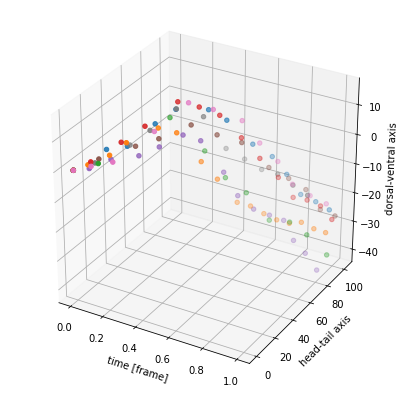

In [19]:
from mpl_toolkits.mplot3d import Axes3D

animal_13_1 = reach_traces.loc[reach_traces['animal_name'] == '13_1']

file_names = animal_13_1['file'].unique()

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

for f in file_names:
    df = animal_13_1.loc[animal_13_1['file'] == f]

    ax.set_xlabel('time [frame]')
    ax.set_ylabel('head-tail axis')
    ax.set_zlabel('dorsal-ventral axis')

    ax.scatter(xs=df['t_norm'], ys=df['x'], zs=df['y'])
    
means = animal_13_1.groupby('t_norm').mean().reset_index()
#ax.scatter(xs = means['t_norm'], ys=means['x'], zs=means['y'])
    
#fig.savefig('3d_reaching_trajectory_13_1_all.png', dpi=300, bbox_inches='tight')

In [13]:
animal_13_1.groupby('t_norm').mean().reset_index()

,t_norm,x,y,t,x_norm,y_norm
0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,0.066667,3.600783,1.890903,1.0,0.039722,0.063205
2,0.071429,3.995737,0.648798,1.0,0.048067,0.016033
3,0.076923,4.737453,2.709947,1.0,0.047757,0.099295
4,0.083333,18.988229,3.231116,1.0,0.200718,0.140778
...,...,...,...,...,...,...
60,0.916667,94.601443,-21.551216,11.0,1.000000,-0.938978
61,0.923077,99.200002,-24.201013,12.0,1.000000,-0.886750
62,0.928571,81.323000,-35.747797,13.0,0.978277,-0.883418
63,0.933333,89.893925,-29.456371,14.0,0.991654,-0.984597


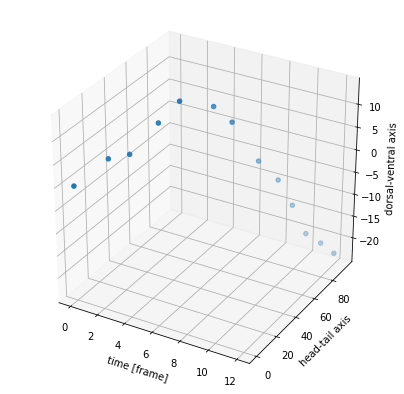

In [24]:
animal_13_1 = reach_traces.loc[reach_traces['animal_name'] == '13_1']

file_names = animal_13_1['file'].unique()

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

f = file_names[0]
df = animal_13_1.loc[animal_13_1['file'] == f]

ax.set_xlabel('time [frame]')
ax.set_ylabel('head-tail axis')
ax.set_zlabel('dorsal-ventral axis')

ax.scatter(xs=df['t'], ys=df['x'], zs=df['y'])
    
fig.savefig('3d_reaching_trajectory_13_1_first_trial.png', dpi=300, bbox_inches='tight')

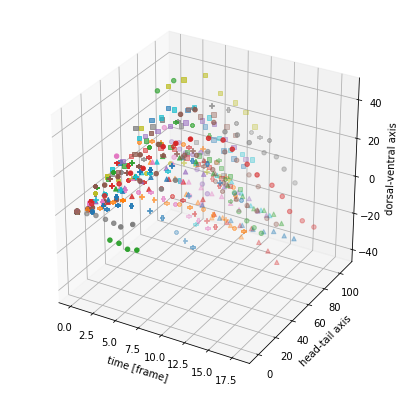

In [29]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

animal_names = reach_traces['animal_name'].unique()

animal_name_symbols = {
    '13_1': '^',
    '13_2': 's',
    '13_3': 'P',
    '13_4': 'o'
}

for a in animal_names:
    animal_df = reach_traces.loc[reach_traces['animal_name'] == a]

    file_names = animal_df['file'].unique()


    for f in file_names:
        df = animal_df.loc[animal_df['file'] == f]

        ax.set_xlabel('time [frame]')
        ax.set_ylabel('head-tail axis')
        ax.set_zlabel('dorsal-ventral axis')

        ax.scatter(xs=df['t'], ys=df['x'], zs=df['y'], marker=animal_name_symbols[a])
    
fig.savefig('3d_reaching_trajectory_all_animals_all.png', dpi=300, bbox_inches='tight')

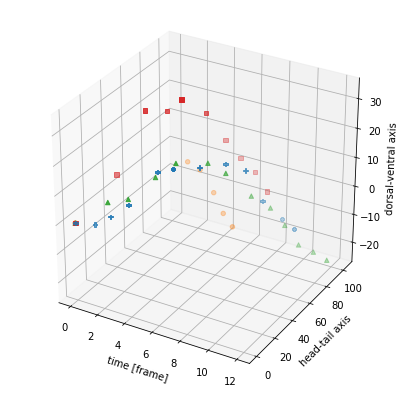

In [30]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

animal_names = reach_traces['animal_name'].unique()

animal_name_symbols = {
    '13_1': '^',
    '13_2': 's',
    '13_3': 'P',
    '13_4': 'o'
}

for a in animal_names:
    animal_df = reach_traces.loc[reach_traces['animal_name'] == a]

    file_names = animal_df['file'].unique()


    f = file_names[0]
    df = animal_df.loc[animal_df['file'] == f]

    ax.set_xlabel('time [frame]')
    ax.set_ylabel('head-tail axis')
    ax.set_zlabel('dorsal-ventral axis')

    ax.scatter(xs=df['t'], ys=df['x'], zs=df['y'], marker=animal_name_symbols[a])
    
fig.savefig('3d_reaching_trajectory_all_animals_first.png', dpi=300, bbox_inches='tight')

In [10]:
reach_traces.head()

,x,y,t,t_norm,x_norm,y_norm,file,animal_name
0,0.000000,0.000000,0,0.000000,0.000000,0.000000,./SPreaching/10DLC_resnet50_SPNreachingSep9shu...,13_3
1,5.890015,-0.716797,1,0.090909,0.081151,-0.042111,./SPreaching/10DLC_resnet50_SPNreachingSep9shu...,13_3
2,8.043976,2.738953,2,0.181818,0.110828,0.160912,./SPreaching/10DLC_resnet50_SPNreachingSep9shu...,13_3
3,12.363617,6.933441,3,0.272727,0.170342,0.407335,./SPreaching/10DLC_resnet50_SPNreachingSep9shu...,13_3
4,28.289673,15.168213,4,0.363636,0.389767,0.891122,./SPreaching/10DLC_resnet50_SPNreachingSep9shu...,13_3


In [27]:
output_df = []

normed_traces = []

for a in ['13_1','13_2', '13_3', '13_4']:

    df = reach_traces.loc[reach_traces['animal_name'] == a, :]

    bins = np.linspace(0, 1, 5)
    df['t_norm_bin'] = df.apply(lambda row: np.digitize(row['t_norm'], bins, right=False), axis=1)

    df.t_norm_bin.loc[df['t'] == 0] = 0

    means = df.groupby('t_norm_bin')[['x', 'y', 'x_norm', 'y_norm']].mean()
    stdevs = df.groupby('t_norm_bin')[['x', 'y', 'x_norm', 'y_norm']].std()

    output_df.append(means.merge(stdevs, on='t_norm_bin', suffixes=('_mean', '_stdev')))
    normed_traces.append(df)

/Users/yamauc0000/Documents/PoseProcessor/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/yamauc0000/Documents/PoseProcessor/.venv/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/yamauc0000/Documents/PoseProcessor/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [21]:
d = reach_traces.groupby('file')['t'].max().reset_index()

d.loc[d['t'] !=0].t.mean()

10.61111111111111

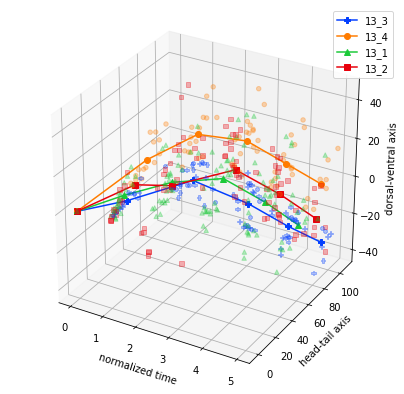

In [41]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

animal_names = reach_traces['animal_name'].unique()

animal_name_symbols = {
    '13_1': '^',
    '13_2': 's',
    '13_3': 'P',
    '13_4': 'o'
}

colors = sns.color_palette('bright')

for i, a in enumerate(animal_names):
    animal_df = normed_traces[i]

    file_names = animal_df['file'].unique()
    col = colors[i]

    for f in file_names:
        df = animal_df.loc[animal_df['file'] == f]

        ax.set_xlabel('normalized time')
        ax.set_ylabel('head-tail axis')
        ax.set_zlabel('dorsal-ventral axis')

        ax.scatter(xs=df['t_norm_bin'], ys=df['x'], zs=df['y'], marker=animal_name_symbols[a], color=col, alpha=0.3)

    animal_df = output_df[i]
    ax.plot(
        xs=list(animal_df.index),
        ys=animal_df['x_mean'],
        zs=animal_df['y_mean'],
        marker=animal_name_symbols[a],
        color=col,
        label=a
    )

plt.legend()
    
fig.savefig('3d_reaching_trajectory_all_animals_all.pdf', bbox_inches='tight')
fig.savefig('3d_reaching_trajectory_all_animals_all.png', dpi=300, bbox_inches='tight')


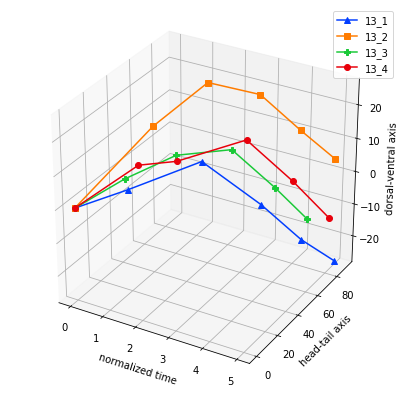

In [63]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

animal_names = reach_traces['animal_name'].unique()

animal_name_symbols = {
    '13_1': '^',
    '13_2': 's',
    '13_3': 'P',
    '13_4': 'o'
}

colors = sns.color_palette('bright')

for i, a in enumerate(['13_1','13_2','13_3','13_4']):
    animal_df = normed_traces[i]

    file_names = animal_df['file'].unique()
    col = colors[i]

    animal_df = output_df[i]
    ax.plot(
        xs=list(animal_df.index),
        ys=animal_df['x_mean'],
        zs=animal_df['y_mean'],
        marker=animal_name_symbols[a],
        color=col,
        label=a
    )

ax.set_xlabel('normalized time')
ax.set_ylabel('head-tail axis')
ax.set_zlabel('dorsal-ventral axis')

plt.legend()
    
fig.savefig('3d_reaching_trajectory_all_animals_means.pdf', bbox_inches='tight')
fig.savefig('3d_reaching_trajectory_all_animals_means.png', dpi=300, bbox_inches='tight')

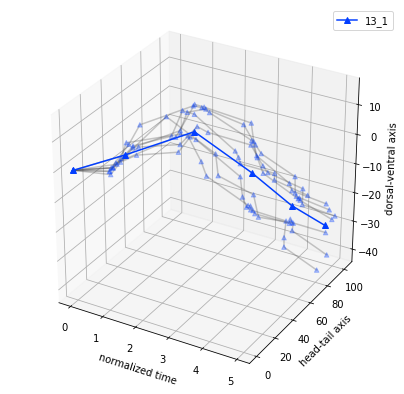

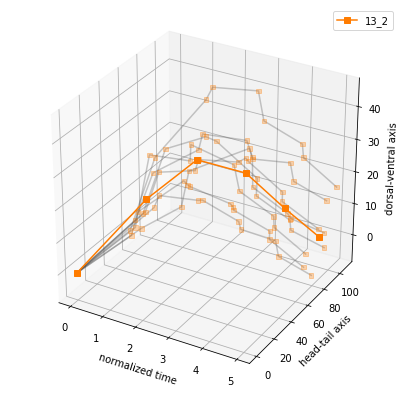

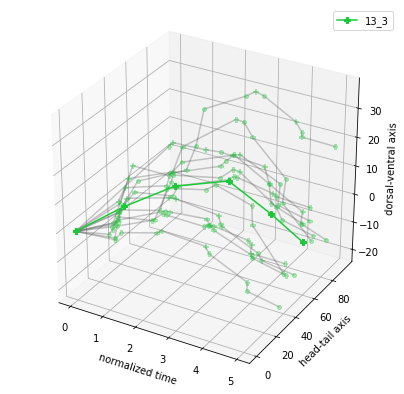

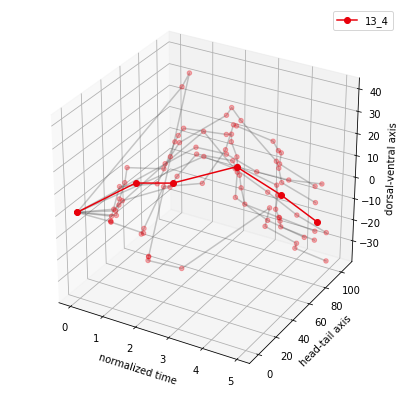

In [64]:
animal_names = reach_traces['animal_name'].unique()

animal_name_symbols = {
    '13_1': '^',
    '13_2': 's',
    '13_3': 'P',
    '13_4': 'o'
}

colors = sns.color_palette('bright')

for i, a in enumerate(['13_1','13_2','13_3','13_4']):
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')

    animal_df = normed_traces[i]

    file_names = animal_df['file'].unique()
    col = colors[i]

    for f in file_names:
        df = animal_df.loc[animal_df['file'] == f]

        ax.set_xlabel('time [frame]')
        ax.set_ylabel('head-tail axis')
        ax.set_zlabel('dorsal-ventral axis')

        ax.scatter(xs=df['t_norm_bin'], ys=df['x'], zs=df['y'], marker=animal_name_symbols[a], color=col, alpha=0.3)
        ax.plot(xs=df['t_norm_bin'], ys=df['x'], zs=df['y'], color=[0.3, 0.3, 0.3], alpha=0.3)

    animal_df = output_df[i]
    ax.plot(
        xs=list(animal_df.index),
        ys=animal_df['x_mean'],
        zs=animal_df['y_mean'],
        marker=animal_name_symbols[a],
        color=col,
        label=a
    )

    ax.set_xlabel('normalized time')
    ax.set_ylabel('head-tail axis')
    ax.set_zlabel('dorsal-ventral axis')

    plt.legend()

    fig.savefig(f'3d_reaching_trajectory_one_animal_{a}.pdf', bbox_inches='tight')
    fig.savefig(f'3d_reaching_trajectory_one_animal_{a}.png',dpi=300, bbox_inches='tight')

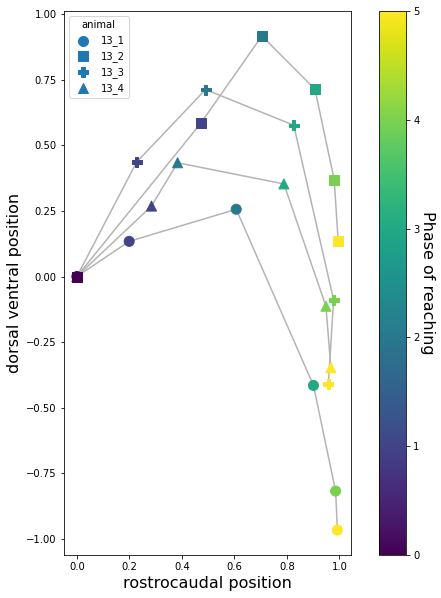

In [22]:
f, ax = plt.subplots(figsize=(10, 10))

#ax.errorbar(output_df[0]['x_mean'], output_df[0]['y_mean'], xerr=output_df[0]['x_stdev'], yerr=output_df[0]['y_stdev'], fmt='.k', zorder=-32)
ax.scatter(
    output_df[0]['x_norm_mean'],
    output_df[0]['y_norm_mean'],
    c=list(output_df[0].index),
    s=100,
    label='13_1'
)

ax.plot(
    output_df[0]['x_norm_mean'],
    output_df[0]['y_norm_mean'],
    color=[0.7, 0.7, 0.7, 1],
    zorder=-32,
    
)

ax.scatter(
    output_df[1]['x_norm_mean'],
    output_df[1]['y_norm_mean'],
    c=list(output_df[1].index),
    s=100,
    marker='s',
    label='13_2'
)
ax.plot(
    output_df[1]['x_norm_mean'],
    output_df[1]['y_norm_mean'],
    color=[0.7, 0.7, 0.7, 1],
    zorder=-32,
)

ax.scatter(
    output_df[2]['x_norm_mean'],
    output_df[2]['y_norm_mean'],
    c=list(output_df[1].index),
    s=100,
    marker='P',
    label='13_3'
)
ax.plot(
    output_df[2]['x_norm_mean'],
    output_df[2]['y_norm_mean'],
    color=[0.7, 0.7, 0.7, 1],
    zorder=-32,
)

sc = ax.scatter(
    output_df[3]['x_norm_mean'],
    output_df[3]['y_norm_mean'],
    c=list(output_df[2].index),
    s=100,
    marker='^',
    label='13_4'
)
ax.plot(
    output_df[3]['x_norm_mean'],
    output_df[3]['y_norm_mean'],
    color=[0.7, 0.7, 0.7, 1],
    zorder=-32,
)

plt.legend(title='animal')
cbar = plt.colorbar(sc,  orientation="vertical")
cbar.ax.set_xticklabels([f'{t:.0f}%' for t in np.linspace(0, 100, 6)]);
cbar.set_label('Phase of reaching', rotation=270, fontsize=16, labelpad=15)

ax.set_xlabel('rostrocaudal position', fontsize=16)
ax.set_ylabel('dorsal ventral position', fontsize=16)
ax.set_aspect('equal', 'box')

f.savefig('reaching_trajectories_normalized.png', dpi=300, bbox_inches='tight')

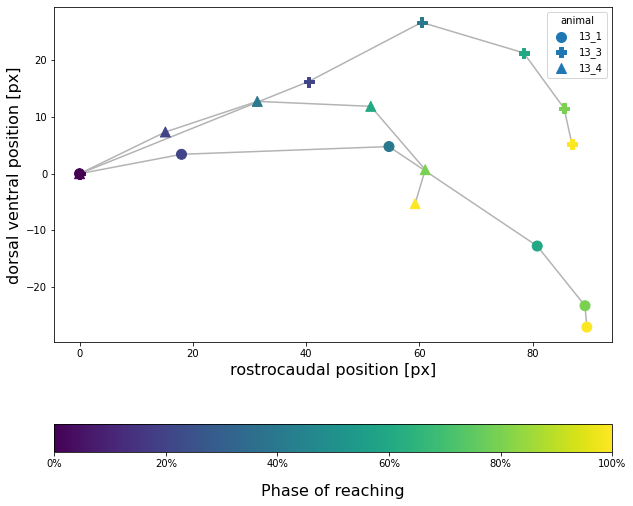

In [21]:
f, ax = plt.subplots(figsize=(10, 10))

#ax.errorbar(output_df[0]['x_mean'], output_df[0]['y_mean'], xerr=output_df[0]['x_stdev'], yerr=output_df[0]['y_stdev'], fmt='.k', zorder=-32)
ax.scatter(
    output_df[0]['x_mean'],
    output_df[0]['y_mean'],
    c=list(output_df[0].index),
    s=100,
    label='13_1'
)

ax.plot(
    output_df[0]['x_mean'],
    output_df[0]['y_mean'],
    color=[0.7, 0.7, 0.7, 1],
    zorder=-32,
    
)

ax.scatter(
    output_df[1]['x_mean'],
    output_df[1]['y_mean'],
    c=list(output_df[1].index),
    s=100,
    marker='P',
    label='13_3'
)
ax.plot(
    output_df[1]['x_mean'],
    output_df[1]['y_mean'],
    color=[0.7, 0.7, 0.7, 1],
    zorder=-32,
)

sc = ax.scatter(
    output_df[2]['x_mean'],
    output_df[2]['y_mean'],
    c=list(output_df[2].index),
    s=100,
    marker='^',
    label='13_4'
)
ax.plot(
    output_df[2]['x_mean'],
    output_df[2]['y_mean'],
    color=[0.7, 0.7, 0.7, 1],
    zorder=-32,
)

plt.legend(title='animal')
cbar = plt.colorbar(sc,  orientation="horizontal")
cbar.ax.set_xticklabels([f'{t:.0f}%' for t in np.linspace(0, 100, 6)]);
cbar.set_label('Phase of reaching', fontsize=16, labelpad=15)

ax.set_xlabel('rostrocaudal position [px]', fontsize=16)
ax.set_ylabel('dorsal ventral position [px]', fontsize=16)
ax.set_aspect('equal', 'box')

f.savefig('reaching_trajectories.png', dpi=300, bbox_inches='tight')

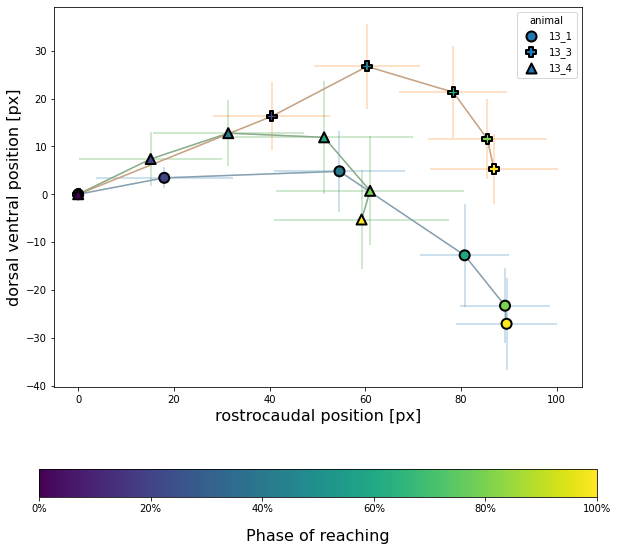

In [22]:
f, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(
    output_df[0]['x_mean'],
    output_df[0]['y_mean'],
    xerr=output_df[0]['x_stdev'],
    yerr=output_df[0]['y_stdev'],
    marker=None,
    linestyle=None,
    alpha=0.3,
    zorder=-32)

ax.scatter(
    output_df[0]['x_mean'],
    output_df[0]['y_mean'],
    c=list(output_df[0].index),
    s=100,
    linewidths=2,
    edgecolors='black',
    label='13_1'
)

ax.plot(
    output_df[0]['x_mean'],
    output_df[0]['y_mean'],
    color=[0.7, 0.7, 0.7, 1],
    zorder=-32,
    
)

ax.errorbar(
    output_df[1]['x_mean'],
    output_df[1]['y_mean'],
    xerr=output_df[1]['x_stdev'],
    yerr=output_df[1]['y_stdev'],
    marker=None,
    linestyle=None,
    alpha=0.3,
    zorder=-32)

ax.scatter(
    output_df[1]['x_mean'],
    output_df[1]['y_mean'],
    c=list(output_df[1].index),
    s=100,
    marker='P',
    linewidths=2,
    edgecolors='black',
    label='13_3'
)
ax.plot(
    output_df[1]['x_mean'],
    output_df[1]['y_mean'],
    color=[0.7, 0.7, 0.7, 1],
    zorder=-32,
)

ax.errorbar(
    output_df[2]['x_mean'],
    output_df[2]['y_mean'],
    xerr=output_df[2]['x_stdev'],
    yerr=output_df[2]['y_stdev'],
    marker=None,
    linestyle=None,
    alpha=0.3,
    zorder=-32)

sc = ax.scatter(
    output_df[2]['x_mean'],
    output_df[2]['y_mean'],
    c=list(output_df[2].index),
    s=100,
    marker='^',
    linewidths=2,
    edgecolors='black',
    label='13_4'
)
ax.plot(
    output_df[2]['x_mean'],
    output_df[2]['y_mean'],
    color=[0.7, 0.7, 0.7, 1],
    zorder=-32,
)

plt.legend(title='animal')
cbar = plt.colorbar(sc,  orientation="horizontal")
cbar.ax.set_xticklabels([f'{t:.0f}%' for t in np.linspace(0, 100, 6)]);
cbar.set_label('Phase of reaching', fontsize=16, labelpad=15)

ax.set_xlabel('rostrocaudal position [px]', fontsize=16)
ax.set_ylabel('dorsal ventral position [px]', fontsize=16)
ax.set_aspect('equal', 'box')

f.savefig('reaching_trajectories_error_lines.png', dpi=300, bbox_inches='tight')

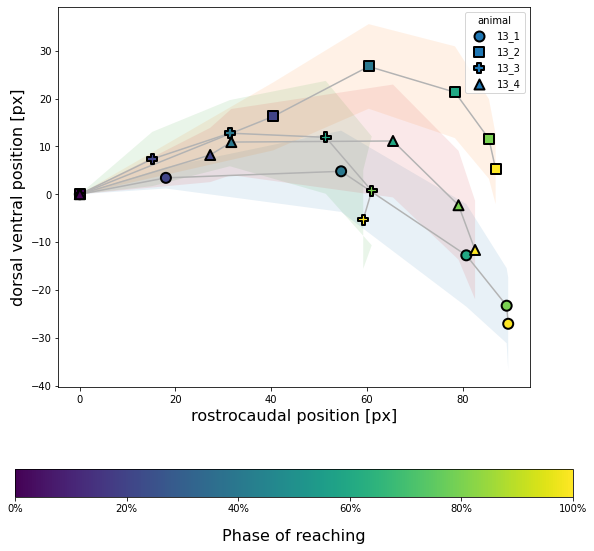

In [23]:
f, ax = plt.subplots(figsize=(10, 10))

ax.fill_between(
    output_df[0]['x_mean'],
    output_df[0]['y_mean'] - output_df[0]['y_stdev'],
    output_df[0]['y_mean'] + output_df[0]['y_stdev'],
    alpha=0.1,
    zorder=-32
)

ax.scatter( 
    output_df[0]['x_mean'],
    output_df[0]['y_mean'],
    c=list(output_df[0].index),
    s=100,
    linewidths=2,
    edgecolors='black',
    label='13_1'
)

ax.plot(
    output_df[0]['x_mean'],
    output_df[0]['y_mean'],
    color=[0.7, 0.7, 0.7, 1],
    zorder=-32,
    
)

ax.fill_between(
    output_df[1]['x_mean'],
    output_df[1]['y_mean'] - output_df[1]['y_stdev'],
    output_df[1]['y_mean'] + output_df[1]['y_stdev'],
    alpha=0.1,
    zorder=-32
)

ax.scatter(
    output_df[1]['x_mean'],
    output_df[1]['y_mean'],
    c=list(output_df[1].index),
    s=100,
    marker='s',
    linewidths=2,
    edgecolors='black',
    label='13_2'
)
ax.plot(
    output_df[1]['x_mean'],
    output_df[1]['y_mean'],
    color=[0.7, 0.7, 0.7, 1],
    zorder=-32,
)


ax.fill_between(
    output_df[2]['x_mean'],
    output_df[2]['y_mean'] - output_df[2]['y_stdev'],
    output_df[2]['y_mean'] + output_df[2]['y_stdev'],
    alpha=0.1,
    zorder=-32
)


sc = ax.scatter(
    output_df[2]['x_mean'],
    output_df[2]['y_mean'],
    c=list(output_df[2].index),
    s=100,
    marker='P',
    linewidths=2,
    edgecolors='black',
    label='13_3'
)
ax.plot(
    output_df[2]['x_mean'],
    output_df[2]['y_mean'],
    color=[0.7, 0.7, 0.7, 1],
    zorder=-32,
)

ax.fill_between(
    output_df[3]['x_mean'],
    output_df[3]['y_mean'] - output_df[2]['y_stdev'],
    output_df[3]['y_mean'] + output_df[2]['y_stdev'],
    alpha=0.1,
    zorder=-32
)


sc = ax.scatter(
    output_df[3]['x_mean'],
    output_df[3]['y_mean'],
    c=list(output_df[2].index),
    s=100,
    marker='^',
    linewidths=2,
    edgecolors='black',
    label='13_4'
)
ax.plot(
    output_df[3]['x_mean'],
    output_df[3]['y_mean'],
    color=[0.7, 0.7, 0.7, 1],
    zorder=-32,
)

plt.legend(title='animal')
cbar = plt.colorbar(sc,  orientation="horizontal")
cbar.ax.set_xticklabels([f'{t:.0f}%' for t in np.linspace(0, 100, 6)]);
cbar.set_label('Phase of reaching', fontsize=16, labelpad=15)

ax.set_xlabel('rostrocaudal position [px]', fontsize=16)
ax.set_ylabel('dorsal ventral position [px]', fontsize=16)
ax.set_aspect('equal', 'box')

f.savefig('reaching_trajectories_error_shaded.png', dpi=300, bbox_inches='tight')
f.savefig('reaching_trajectories_error_shaded.svg', dpi=300, bbox_inches='tight')

In [24]:
from sklearn.cluster import AgglomerativeClustering, KMeans

X = np.column_stack((reaching_df['end_point_x'], reaching_df['end_point_y']))

clustering_ag = AgglomerativeClustering(n_clusters=3).fit(X)
clustering_km = KMeans(n_clusters=3).fit(X)


reaching_df['ag_labels'] = clustering_ag.labels_
reaching_df['km_labels'] = clustering_km.labels_


In [66]:


reaching_1 = reaching_df.loc[reaching_df['animal_name'] == '13_1', ['end_point_x', 'end_point_y']].values
reaching_2 = reaching_df.loc[reaching_df['animal_name'] == '13_2', ['end_point_x', 'end_point_y']].values
reaching_3 = reaching_df.loc[reaching_df['animal_name'] == '13_3', ['end_point_x', 'end_point_y']].values
reaching_4 = reaching_df.loc[reaching_df['animal_name'] == '13_4', ['end_point_x', 'end_point_y']].values

reaching_endpoint_coords = [reaching_1,reaching_2, reaching_3, reaching_4]
reaching_endpoint_centroid = reaching_df.groupby('animal_name')[['end_point_x', 'end_point_y']].mean().reset_index()

centroid_x = []
centroid_y = []
animal_names = []
mean_dist = []
stdev_dist = []
mean_dist_norm = []
stdev_dist_norm = []
centroid_dist = []
n_reaches = []

all_dists = []
all_dists_animals = []
grouping = []

all_reaches_centroid = reaching_df[['end_point_x', 'end_point_y']].mean().values

for _, row in reaching_endpoint_centroid.iterrows():
    a_name = row['animal_name']
    animal_names.append(a_name)
    centroid = np.array([row['end_point_x'], row['end_point_y']])
    centroid_x.append(centroid[0])
    centroid_y.append(centroid[1])
    
    df = reaching_df.loc[reaching_df['animal_name'] == a_name]
    coords = np.column_stack((df['end_point_x'], df['end_point_y']))
    
    dists = np.linalg.norm(coords - centroid, axis=1)
    
    mean_dist.append(dists.mean())
    stdev_dist.append(dists.std())
    
    c_dist = np.linalg.norm(centroid)
    centroid_dist.append(c_dist)
    
    norm_dists = dists / c_dist
    mean_dist_norm.append(norm_dists.mean())
    stdev_dist_norm.append(norm_dists.std())
    
    n_reaches.append(len(dists))
    
    # add the within animal distances
    all_dists += list(dists)
    all_dists_animals += len(dists) * [a_name]
    grouping += len(dists) * [a_name]
    
    # add the all animals distnace
    dist_to_all_centroid = np.linalg.norm(coords - all_reaches_centroid, axis=1)
    all_dists += list(dist_to_all_centroid)
    all_dists_animals += len(dists) * [a_name]
    grouping += len(dists) * ['all animals']
    
    
cluster_df = pd.DataFrame(
    {
        'animal_name': animal_names,
        'centroid_x': centroid_x,
        'centroid_y': centroid_y,
        'mean_dist': mean_dist,
        'stdev_dist': stdev_dist,
        'mean_dist_norm': mean_dist_norm,
        'stdev_dist_norm': stdev_dist_norm,
        'centroid_dist': centroid_dist,
        'n_reaches': n_reaches
        
    }
)
 
all_dists_df = pd.DataFrame(
    {
        'animal_name': all_dists_animals,
        'dist': all_dists,
        'grouping': grouping
        
    }
)

# ax = sns.kdeplot(reaching_1['end_point_x'], reaching_1['end_point_y'])
# ax = sns.kdeplot(reaching_3['end_point_x'], reaching_3['end_point_y'])
# ax = sns.kdeplot(reaching_4['end_point_x'], reaching_4['end_point_y'])



In [67]:
reaching_cluster_centroids = reaching_df.groupby('animal_name')[['end_point_x', 'end_point_y']].mean()

reaching_cluster_st_devs = reaching_df.groupby('animal_name')[['end_point_x', 'end_point_y']].std()


In [49]:
reaching_df = reaching_df.drop(41, axis=0)

In [50]:
reaching_df.iloc[39]

filename              ./SPreaching/oDLC_resnet50_SPNreachingSep9shuf...
distance                                                         81.883
max_speed                                                       30.8947
max_speed_smoothed                                              8.94239
end_point_x                                                      81.883
end_point_y                                                    0.315181
initiation_index                                                     27
end_point_index                                                      36
animal_name                                                        13_2
Name: 40, dtype: object

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

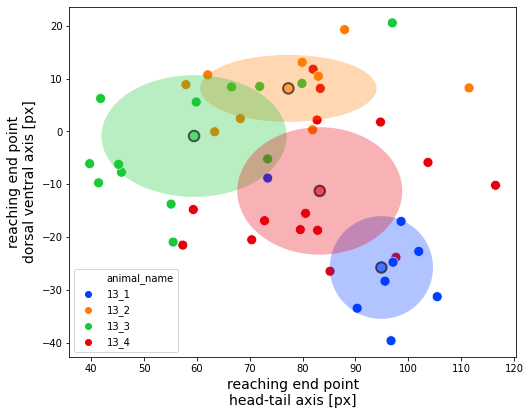

In [68]:
from matplotlib.patches import Ellipse

f, ax = plt.subplots(figsize=(8, 8))
ax = sns.scatterplot(
    x='end_point_x',
    y='end_point_y',
    hue='animal_name',
    s=100,
    data=reaching_df,
    palette=sns.color_palette("bright", 4),
    ax=ax
)

ax.set_aspect('equal', 'box')
ax.set_xlabel(f'reaching end point\nhead-tail axis [px]', fontsize=14)
ax.set_ylabel('reaching end point\ndorsal ventral axis [px]', fontsize=14)

# make ellipses
colors = sns.color_palette("bright", 4)
for i, a in enumerate(['13_1', '13_2', '13_3', '13_4']):
    cent = (reaching_cluster_centroids.loc[a]['end_point_x'], reaching_cluster_centroids.loc[a]['end_point_y'])
    width = 2 * reaching_cluster_st_devs.loc[a]['end_point_x']
    height = 2* reaching_cluster_st_devs.loc[a]['end_point_y']
    el = Ellipse(cent, width=width, height=height, angle=0, alpha=0.3, facecolor=colors[i])
    ax.add_patch(el)
    
    el_cent = Ellipse(
        cent,
        width=2,
        height=2,
        angle=0,
        alpha=0.6,
        facecolor=colors[i],
        edgecolor='black',
        linewidth=2
    )
    ax.add_patch(el_cent)


f.savefig('reaching_endpoints_front.png', dpi=300, bbox_inches='tight')
f.savefig('reaching_endpoints_front.svg', dpi=300, bbox_inches='tight')
f.savefig('reaching_endpoints_front.eps', dpi=300, bbox_inches='tight')
f.savefig('reaching_endpoints_front.pdf', dpi=300, bbox_inches='tight')

In [73]:
csv_dir_front = './SP reaching_front_view/'
path_pattern = path.join(csv_dir, '*.csv')
reaching_files = glob.glob(path_pattern)
reaching_files.sort()

prefixes_13_1_front = string.ascii_lowercase[0:9]
reaching_13_1_front = {path.join(csv_dir_front, l + 'DeepCut_resnet50_SPNreachingSep9shuffle1_500000.csv'): '13_1' for l in prefixes_13_1}

prefixes_13_2_front = string.ascii_lowercase[12:22] + 'h'
reaching_13_2_front = {path.join(csv_dir_front, l + 'DLC_resnet50_SPNreachingSep9shuffle1_500000.csv'): '13_2' for l in prefixes_13_2}

prefixes_13_3_front = np.arange(1, 19)
reaching_13_3_front = {path.join(csv_dir_front, str(l) + 'DLC_resnet50_SPNreachingSep9shuffle1_500000.csv'): '13_3' for l in prefixes_13_3}

prefixes_13_4_front = np.arange(20, 42)
reaching_13_4_front = {path.join(csv_dir_front, str(l) + 'DLC_resnet50_SPNreachingSep9shuffle1_500000.csv'): '13_4' for l in prefixes_13_4}

reaching_animals = {**reaching_13_1_front, **reaching_13_2_front, **reaching_13_3_front, **reaching_13_4_front}

In [77]:
end_point_x = []
end_point_y = []
files = []
animal_name = []

reaching_files = list(reaching_animals.keys())

for i, f in enumerate(reaching_files):
    if f in reaching_df['filename'].values:
    
        # get the trace and baseline subtract
        df = pd.read_csv(f, header=[1,2])
        hand_x = -1 * baseline_subtract(df['Hand']['x'].values)
        hand_y = baseline_subtract(df['Hand']['y'].values)

        # get the coordinates from the pax peak index
        end_point_index = reaching_df.loc[reaching_df['filename'] == f]['end_point_index'].values
        initiation_index = reaching_df.loc[reaching_df['filename'] == f]['initiation_index'].values


        x_coord = hand_x[end_point_index] - hand_x[0]
        y_coord = hand_y[end_point_index] - hand_y[0]

        # save to array
        end_point_x.append(x_coord[0])
        end_point_y.append(y_coord[0])
        files.append(f)
        animal_name.append(reaching_animals[f])

# make df
reaching_front_df = pd.DataFrame(
    {
        'filename': files,
        'animal_name': animal_name,
        'end_point_x': end_point_x,
        'end_point_y': end_point_y
    }
)



In [78]:
reaching_front_df.head()

,filename,animal_name,end_point_x,end_point_y


In [71]:
reaching_front_cluster_centroids = reaching_front_df.groupby('animal_name')[['end_point_x', 'end_point_y']].mean()
reaching_front_cluster_st_devs = reaching_front_df.groupby('animal_name')[['end_point_x', 'end_point_y']].std()


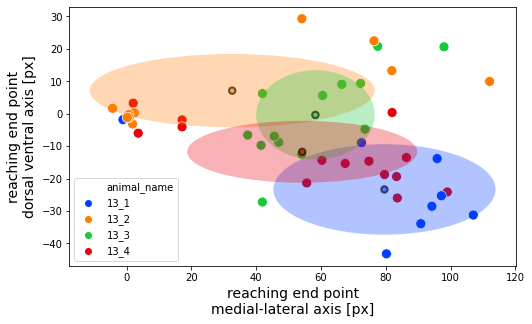

In [79]:
# plot
f, ax = plt.subplots(figsize=(8, 8))
ax = sns.scatterplot(
    x='end_point_x',
    y='end_point_y',
    hue='animal_name',
    s=100,
    data=reaching_front_df,
    palette=sns.color_palette("bright", 4),
    ax=ax
)

ax.set_aspect('equal', 'box')
ax.set_xlabel(f'reaching end point\nmedial-lateral axis [px]', fontsize=14)
ax.set_ylabel('reaching end point\ndorsal ventral axis [px]', fontsize=14)

# make ellipses
colors = sns.color_palette("bright", 4)
for i, a in enumerate(['13_1', '13_2', '13_3', '13_4']):
    cent = (reaching_front_cluster_centroids.loc[a]['end_point_x'], reaching_front_cluster_centroids.loc[a]['end_point_y'])
    width = 2 * reaching_front_cluster_st_devs.loc[a]['end_point_x']
    height = 2* reaching_front_cluster_st_devs.loc[a]['end_point_y']
    el = Ellipse(cent, width=width, height=height, angle=0, alpha=0.3, facecolor=colors[i])
    ax.add_patch(el)
    
    el_cent = Ellipse(
        cent,
        width=2,
        height=2,
        angle=0,
        alpha=0.6,
        facecolor=colors[i],
        edgecolor='black',
        linewidth=2
    )
    ax.add_patch(el_cent)

f.savefig('reaching_endpoints_front.png', dpi=300, bbox_inches='tight')

The best fit line: 
slipe = 0.9461241444150491 
intercept = -0.0402066482304706 
 r^2 =0.8315073361277155 


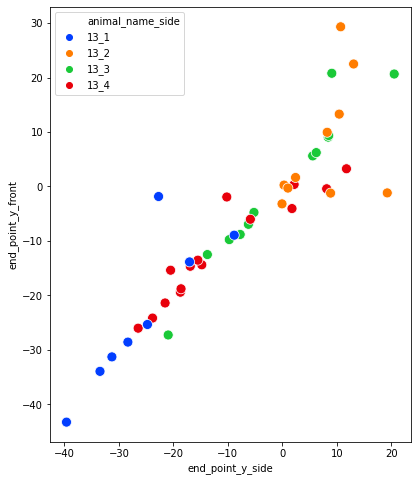

In [86]:
# plot
f, ax = plt.subplots(figsize=(8, 8))

all_reaching_df = reaching_df.merge(reaching_front_df, on='filename', suffixes=('_side', '_front'))

ax = sns.scatterplot(x='end_point_y_side', y='end_point_y_front', hue='animal_name_side', data=all_reaching_df, s=100,
    palette=sns.color_palette("bright", 4), ax=ax)

slope, intercept, r_value, _, _ = stats.linregress(all_reaching_df['end_point_y_side'].values, all_reaching_df['end_point_y_front'].values)


ax.set_aspect('equal', 'box')

print(f'The best fit line: \nslipe = {slope} \nintercept = {intercept} \nr^2 ={r_value**2} ')

f.savefig('front_verus_side_reaching_endpoint.png', dpi=300, bbox_inches='tight')

In [65]:
all_reaching_df

NameError: name 'all_reaching_df' is not defined

1025.0933443476501
717.7563636824639
0.29981365341979627


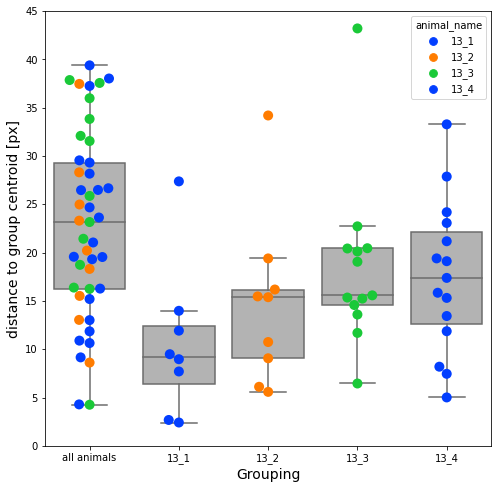

In [84]:
f, ax = plt.subplots(figsize=(8, 8))
order = ['all animals', '13_1', '13_2', '13_3', '13_4']

ax = sns.swarmplot(
    x='grouping',
    y='dist',
    hue='animal_name',
    palette=sns.color_palette("bright", 3),
    s=10,
    order = order,
    data=all_dists_df,
    ax=ax
)


ax = sns.boxplot(
    x='grouping',
    y='dist',
    data=all_dists_df,
    order=order,
    showfliers = False,
    ax=ax,
    color=[0.7, 0.7, 0.7, 1])

ax.set_xlabel('Grouping', fontsize=14)
ax.set_ylabel('distance to group centroid [px]', fontsize=14)
ax.set_ylim((0, 45))

f.savefig('reaching_endpoint_centroid_distance.png', dpi=300, bbox_inches='tight')

all_dist= all_dists_df.loc[all_dists_df['grouping'] == 'all animals']['dist'].sum()
by_animal_dist =all_dists_df.loc[all_dists_df['grouping'] != 'all animals']['dist'].sum()

print(all_dist)
print(by_animal_dist)
print((all_dist-by_animal_dist)/all_dist)



In [ ]:
reach_traces_means = reach_traces.groupby(['animal_name', 't'])[['x', 'y', 'x_norm', 'y_norm']].mean().reset_index()

sns.scatterplot(x='x_norm', y='y_norm', hue='t', style='animal_name', data=reach_traces_means, s=50)

In [ ]:
f, ax  = plt.subplots(figsize=(5, 5))

animal_colors = {
    '13_1': np.array([166, 206, 207, 255]) / 255,
    '13_2': np.array([31, 120, 180, 255]) / 255,
    '13_3': np.array([178, 223, 138, 255]) / 255,
    '13_4': np.array([51, 160, 44, 255]) / 255,
    
}

reaching_df['animal_color'] = reaching_df.apply(lambda row: animal_colors[row['animal_name']], axis=1)

ax = sns.regplot(x="distance", y="max_speed", data=reaching_df, ci=None, ax=ax, scatter_kws={'alpha': 0}, line_kws={'color': 'black'})
ax = sns.scatterplot(x="distance", y="max_speed", data=reaching_df, s=50, ci=None, ax=ax, hue='animal_name', palette=sns.color_palette("bright", 4))



ax.set_xlabel('Reach distance [px]', fontsize=14)
ax.set_ylabel('Max reach speed [px / frame]', fontsize=14)

ax.set_xlim((0, 110))

r = stats.pearsonr(reaching_peak_max, reaching_speed_max)[0]

print(f'Pearson r={r:.2}')

f.savefig('reaching_speed_distance_corr.png', dpi=300, bbox_inches='tight')
f.savefig('reaching_speed_distance_corr.pdf', dpi=300, bbox_inches='tight')

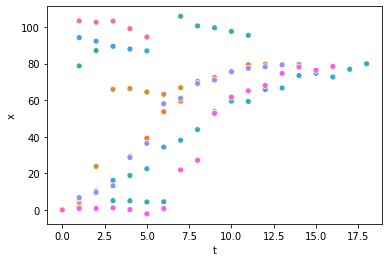

In [79]:
df = reach_traces.loc[reach_traces['animal_name'] == '13_4']

#sns.lineplot(x='t', y='x', data=, hue='animal_name', palette=sns.color_palette("bright", 3))

sns.scatterplot(x='t', y='x', hue='file', data=df, legend=False)

In [80]:
std_peak_max = np.nanstd(reaching_peak_max)
mean_peak_max = np.nanmean(reaching_peak_max)

std_peak_max / mean_peak_max

0.3287968883648491

In [81]:
len(reaching_files)

60

In [82]:
f = reaching_files[15]
df = pd.read_csv(f, header=[1,2])

hand_x = -1 * baseline_subtract(df['Hand']['x'].values)
hand_y = baseline_subtract(df['Hand']['y'].values)
hand_likelihood = df['Hand']['likelihood'].values
t = df.index.to_numpy()

t_clean = t[hand_likelihood > LIKELIHOOD_THRESH]
hand_x_clean = hand_x[hand_likelihood > LIKELIHOOD_THRESH]
hand_y_clean = hand_y[hand_likelihood > LIKELIHOOD_THRESH]
hand_x_smooth = smooth(hand_x_clean, window_len=11, window='flat')

diff = central_difference(t_clean, hand_x_clean)
diff_smooth = central_difference(t_clean, hand_x_smooth)

# ctrl = baseline_subtract(df['handsx']['x'].values)
# ctrl_likelihood = df['handsx']['likelihood'].values
# ctrl_clean = ctrl[ctrl_likelihood > LIKELIHOOD_THRESH]
# ctrl_smooth = smooth(ctrl_clean, window_len=8, window='flat')
height_thresh = calc_peak_thresh(hand_y_smooth[:20], zscore=PEAK_THRESH)

# get the peak location
smooth_peaks, smooth_props = signal.find_peaks(hand_x_smooth, height=height_thresh, distance=30)

if len(smooth_peaks) > 0:
    max_peak_index = np.argmax(smooth_props['peak_heights'])

    search_window = np.clip([smooth_peaks[max_peak_index] - 50, smooth_peaks[max_peak_index] + 50], 0, len(hand_x_clean))
    peaks, props = signal.find_peaks(hand_x_clean[search_window[0]:search_window[1]], height=height_thresh, distance=30)
    reaching_peak_max.append(props['peak_heights'].max())

    peak_max_index = smooth_peaks[np.argmax(smooth_props['peak_heights'])]
    search_start = peak_max_index - 30
    speed_search_window = np.clip([search_start, peak_max_index], 0, len(diff))

    speed_peaks, speed_props = signal.find_peaks(diff[speed_search_window[0]:speed_search_window[1]], height=0)
    reaching_speed_max.append(speed_props['peak_heights'].max())
    speed_peak_index = speed_peaks[np.argmax(speed_props['peak_heights'])]

    speed_peaks_smooth, speed_props_smooth = signal.find_peaks(diff_smooth[speed_search_window[0]:speed_search_window[1]], height=0)
    reaching_speed_max_smooth.append(speed_props_smooth['peak_heights'].max())


    peak_files.append(f)
    animal_names.append(reaching_animals[f])

    speed_profile_window = np.clip([speed_peak_index-50, speed_peak_index+50], 0, len(diff))
    window_left = -1* (speed_peak_index - speed_profile_window[0])
    window_right = speed_profile_window[1] - speed_peak_index
    speed_time_rel = list(np.arange(window_left, window_right))
    speed_times = speed_times + speed_time_rel
    speed_profiles = speed_profiles + list(diff[speed_profile_window[0]:speed_profile_window[1]])
    speed_animal_names = speed_animal_names + len(speed_time_rel)*[reaching_animals[f]]
    
    
    peak_index = speed_peaks[np.argmax(speed_props['peak_heights'])]
    
    
    
    # find the index where the speed crosses the threshold
    # (i.e., the onset of motion)
    initiation_index = peak_max_index
    above_thresh = True
    speed_thresh = calc_peak_thresh(hand_x[:20], zscore=PEAK_THRESH)
    while above_thresh:
        initiation_index -= 1
        above_thresh = diff_smooth[initiation_index] > speed_thresh
    
    reach_trace_x = hand_x_clean[initiation_index:peak_max_index] - hand_x_clean[initiation_index]
    reach_trace_y = hand_y_clean[initiation_index:peak_max_index]- hand_y_clean[initiation_index]
    reach_times = np.arange(len(reach_trace_x))
    reach_times_normed = reach_times / len(reach_trace_x)
            

    print(initiation_index, peak_max_index)
    #plt.scatter(reach_trace_x,reach_trace_y, c=reach_times_normed)
    plt.scatter(reach_times, reach_trace_x)

#     plt.plot(diff_smooth[search_window[0]:peak_max_index])
#     plt.axvline(i - search_window[0])

else:
    no_peak_files.append(f)
#         reaching_peak_max.append(np.nan)
#         reaching_speed_max.append(np.nan)
#         reaching_speed_max_smooth.append(np.nan)

FileNotFoundError: [Errno 2] File ./SP reaching_front_view/sDLC_resnet50_SPNreachingSep9shuffle1_500000.csv does not exist: './SP reaching_front_view/sDLC_resnet50_SPNreachingSep9shuffle1_500000.csv'

In [ ]:
ind = np.argmin(reaching_df.end_point_x)

reaching_df.iloc[ind]

In [ ]:
f = reaching_files[43]
df = pd.read_csv(f, header=[1,2])

hand_y = -1 * baseline_subtract(df['Hand']['x'].values)
hand_likelihood = df['Hand']['likelihood'].values
t = df.index.to_numpy()

t_clean = t[hand_likelihood > LIKELIHOOD_THRESH]
hand_y_clean = hand_y[hand_likelihood > LIKELIHOOD_THRESH]
hand_y_smooth = smooth(hand_y_clean, window_len=11, window='flat')

diff = central_difference(t_clean, hand_y_clean)
diff_smooth = central_difference(t_clean, hand_y_smooth)

# ctrl = baseline_subtract(df['handsx']['x'].values)
# ctrl_likelihood = df['handsx']['likelihood'].values
# ctrl_clean = ctrl[ctrl_likelihood > LIKELIHOOD_THRESH]
# ctrl_smooth = smooth(ctrl_clean, window_len=8, window='flat')
height_thresh = calc_peak_thresh(hand_y_smooth[:20], zscore=PEAK_THRESH)

# get the peak location
smooth_peaks, smooth_props = signal.find_peaks(hand_y_smooth, height=height_thresh, distance=30)

if len(smooth_peaks) > 0:
    max_peak_index = np.argmax(smooth_props['peak_heights'])

    search_window = np.clip([smooth_peaks[max_peak_index] - 50, smooth_peaks[max_peak_index] + 50], 0, len(hand_y_clean))
    peaks, props = signal.find_peaks(hand_y_clean[search_window[0]:search_window[1]], height=height_thresh, distance=30)
    reaching_peak_max.append(props['peak_heights'].max())

    peak_max_index = smooth_peaks[np.argmax(smooth_props['peak_heights'])]
    search_start = peak_max_index - 30
    speed_search_window = np.clip([search_start, peak_max_index], 0, len(diff))

    speed_peaks, speed_props = signal.find_peaks(diff[speed_search_window[0]:speed_search_window[1]], height=0)
    reaching_speed_max.append(speed_props['peak_heights'].max())

    speed_peaks_smooth, speed_props_smooth = signal.find_peaks(diff_smooth[speed_search_window[0]:speed_search_window[1]], height=0)
    reaching_speed_max_smooth.append(speed_props_smooth['peak_heights'].max())

    peak_files.append(f)
    animal_names.append(reaching_animals[f])
    
    print(f)
    
    plt.plot(hand_y_clean)
    
reaching_df = reaching_df.drop([4, 43], axis=0)

In [ ]:
reaching_df

[0.10294875 0.21589248 0.29453794 0.18751805]
Index(['13_1', '13_2', '13_3', '13_4'], dtype='object', name='animal_name')


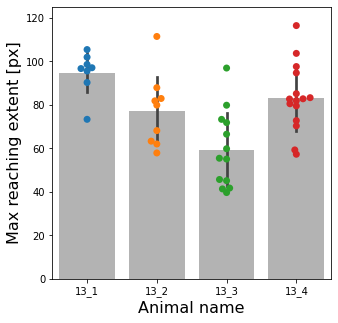

In [83]:
reaching_stdevs = reaching_df.groupby('animal_name')['distance'].std().values
reaching_means = reaching_df.groupby('animal_name')['distance'].mean().values

reaching_cvs = np.divide(reaching_stdevs, reaching_means)

print(reaching_cvs)
print(reaching_df.groupby('animal_name')['distance'].std().index)


f, ax = plt.subplots(figsize=(5, 5))
ax = sns.swarmplot(x='animal_name', y='distance', size=7, data=reaching_df, ax=ax)
ax = sns.barplot(x='animal_name', y='distance', ci='sd', data=reaching_df, ax=ax, color=[0.7, 0.7, 0.7])

ax.set_ylim((0, 125))
ax.set_xlabel('Animal name', fontsize=16)
ax.set_ylabel('Max reaching extent [px]', fontsize=16)

f.savefig('reach_amplitude_stratified_by_animal.png', dpi=300, bbox_inches='tight')

In [ ]:
reaching_df['distance'].std() / reaching_df['distance'].mean()

In [ ]:
plt.scatter(t_clean, hand_y_smooth)
plt.plot(t_clean[peaks], hand_y_smooth[peaks], "x", c='r')
plt.scatter(t_clean, hand_y_clean)

# Grooming

In [223]:
# get file paths
opto_dir = './grooming'
path_pattern = path.join(opto_dir, '*.csv')
grooming_files_opto = glob.glob(path_pattern)
grooming_files_opto.sort()

remove_i = grooming_files_opto.index('./grooming/grooming_frames.csv')
grooming_files_opto.pop(remove_i)

natural_dir = './natural_grooming'
natural_path_pattern = path.join(natural_dir, '*.csv')
grooming_files_natural = glob.glob(natural_path_pattern)
grooming_files_natural.sort()

In [224]:
prefixes_a1 = string.ascii_lowercase[1:27]
grooming_a1 = {path.join(opto_dir, l + 'DeepCut_resnet50_groomingMar5shuffle1_600000.csv'): 'a_1' for l in prefixes_a1}

prefixes_a11 = [str(i) for i in np.arange(2, 21)]
grooming_a11 = {path.join(opto_dir, l + 'DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv'): 'a_11' for l in prefixes_a11}


prefixes_DREADD3 = [str(i) for i in np.arange(1, 5)]
grooming_DREADD3 = {
    path.join(natural_dir, l + 'DLC_resnet50_natural_groomingMay5shuffle1_500000.csv'): 'DREADD3' for l in prefixes_DREADD3
}

prefixes_DREADD4 = [str(i) for i in np.arange(5, 14)]
grooming_DREADD4 = {
    path.join(natural_dir, l + 'DLC_resnet50_natural_groomingMay5shuffle1_500000.csv'): 'DREADD4' for l in prefixes_DREADD4
}

prefixes_DREADD6 = [str(i) for i in np.arange(14, 18)]
grooming_DREADD6 = {
    path.join(natural_dir, l + 'DLC_resnet50_natural_groomingMay5shuffle1_500000.csv'): 'DREADD6' for l in prefixes_DREADD6
}

grooming_animals = {**grooming_a1, **grooming_a11, **grooming_DREADD3, **grooming_DREADD4, **grooming_DREADD6}

In [225]:
list(grooming_animals.keys())

['./grooming/bDeepCut_resnet50_groomingMar5shuffle1_600000.csv',
 './grooming/cDeepCut_resnet50_groomingMar5shuffle1_600000.csv',
 './grooming/dDeepCut_resnet50_groomingMar5shuffle1_600000.csv',
 './grooming/eDeepCut_resnet50_groomingMar5shuffle1_600000.csv',
 './grooming/fDeepCut_resnet50_groomingMar5shuffle1_600000.csv',
 './grooming/gDeepCut_resnet50_groomingMar5shuffle1_600000.csv',
 './grooming/hDeepCut_resnet50_groomingMar5shuffle1_600000.csv',
 './grooming/iDeepCut_resnet50_groomingMar5shuffle1_600000.csv',
 './grooming/jDeepCut_resnet50_groomingMar5shuffle1_600000.csv',
 './grooming/kDeepCut_resnet50_groomingMar5shuffle1_600000.csv',
 './grooming/lDeepCut_resnet50_groomingMar5shuffle1_600000.csv',
 './grooming/mDeepCut_resnet50_groomingMar5shuffle1_600000.csv',
 './grooming/nDeepCut_resnet50_groomingMar5shuffle1_600000.csv',
 './grooming/oDeepCut_resnet50_groomingMar5shuffle1_600000.csv',
 './grooming/pDeepCut_resnet50_groomingMar5shuffle1_600000.csv',
 './grooming/qDeepCut_res

In [226]:
def process_grooming(grooming_files, hand, grooming_type):
    filename = []
    total_angle = []
    total_displacement_angle = []
    total_path_length = []
    animal_names = []
    grooming_types = []


    for f in grooming_files:
        print(f)
        df = pd.read_csv(f, header=[1,2])

        x = df[hand]['x'].values
        y = df[hand]['y'].values

        n_samples = len(x)

        displacement = np.zeros((n_samples, 2))
        for i in range(n_samples):
            if i == 0:
                displacement[i] = 0
            else:
                displacement[i, 0] = x[i] - x[i-1]
                displacement[i, 1] = y[i] - y[i-1]

        displacement_mag = np.linalg.norm(displacement, axis=1)
        displacement_angle = np.arctan2(displacement[:, 1], displacement[:, 0])

        min_disp = np.mean(displacement_mag[0:100]) + (3 * np.std(displacement_mag[0:100]))
        moving = displacement_mag > min_disp

        displacement_angle_moving = displacement_angle
        displacement_angle_moving[np.logical_not(moving)] = 0

        displacement_angle_moving_unwrapped = np.unwrap(displacement_angle_moving)
        diff_angle = central_difference(
            np.arange(len(displacement_angle_moving_unwrapped)),
            displacement_angle_moving_unwrapped
        )

        total_angle.append(np.sum(np.abs(diff_angle)))
        total_displacement_angle.append(np.sum(diff_angle))
        total_path_length.append(np.sum(displacement_mag[moving]))

        filename.append(f)
        animal_names.append(grooming_animals[f])
        grooming_types.append(grooming_type)


    hand_name = [hand] * len(filename)
    grooming_df = pd.DataFrame(
        {
            'file': filename,
            'animal_name': animal_names,
            'grooming_type': grooming_types,
            'total_angle': total_angle,
            'total_displacement_angle': total_displacement_angle,
            'total_path_length': total_path_length,
            'hand': hand_name

        }
    )

    return grooming_df

# f, ax = plt.subplots(5, 1, sharex=True, figsize=(10, 5))
# ax[0].plot(np.arange(len(displacement_mag)), displacement_mag,)
# ax[1].plot(np.arange(len(displacement_angle)), displacement_angle)
# ax[2].plot(moving)
# ax[3].plot(displacement_angle_moving)
# ax[4].plot(np.unwrap(displacement_angle_moving))



In [227]:
d_opto = process_grooming(grooming_files_opto, 'handdx', 'opto')
s_opto = process_grooming(grooming_files_opto, 'handsx', 'opto')

d_nat = process_grooming(grooming_files_natural, 'lefthand', 'natural')
s_nat = process_grooming(grooming_files_natural, 'righthand', 'natural')

grooming_df_opto = pd.concat([d_opto, s_opto])
grooming_df_nat = pd.concat([d_nat, s_nat])

./grooming/10DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv
./grooming/11DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv
./grooming/12DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv
./grooming/13DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv
./grooming/14DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv
./grooming/15DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv
./grooming/16DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv
./grooming/17DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv
./grooming/18DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv
./grooming/20DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv
./grooming/2DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv
./grooming/3DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv
./grooming/4DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv
./grooming/5DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv
./grooming/7DLC_resnet50_Grooming_animal11Apr30shuff

In [229]:
len(d_opto)

39

In [231]:
def merge_and_clean_grooming(d, s):
    merged_grooming = d.merge(s, on='file', suffixes=('_d','_s'))
    
    # remove trials with no grooming
    s_0 = merged_grooming['total_path_length_s'] == 0
    d_0 = merged_grooming['total_path_length_d'] == 0
    not_0 = np.logical_not(np.logical_or(s_0, d_0))
    merged_grooming = merged_grooming.loc[not_0, :]
    
    merged_grooming['path_length_ratio'] = merged_grooming['total_path_length_s'] / merged_grooming['total_path_length_d']
    merged_grooming['ipsi_hand_bias'] = merged_grooming['path_length_ratio'] > 1
    
    return merged_grooming

In [232]:
merged_grooming_opto = merge_and_clean_grooming(d_opto, s_opto)
merged_grooming_nat = merge_and_clean_grooming(d_nat, s_nat)

merged_grooming = pd.concat([merged_grooming_opto, merged_grooming_nat])


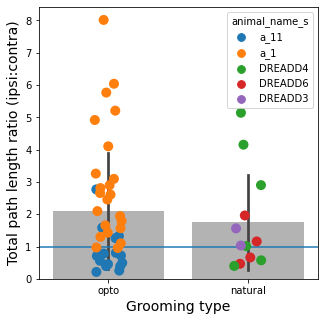

In [119]:
f, ax = plt.subplots(figsize=(5, 5))

b = ax
b = sns.barplot(x='grooming_type_s', y='path_length_ratio', ci='sd', data=merged_grooming, ax=b, color=[0.7, 0.7, 0.7, 1])
b = sns.stripplot(x='grooming_type_s', y='path_length_ratio', hue='animal_name_s', data=merged_grooming, ax=b, size=10)

b.axhline(1)

b.set_xlabel('Grooming type', fontsize=14)
b.set_ylabel('Total path length ratio (ipsi:contra)', fontsize=14)

f.savefig('grooming_path_length_with_natural.png', dpi=300, bbox_inches='tight')
f.savefig('grooming_path_length_with_natural.pdf', dpi=300, bbox_inches='tight')

In [237]:
n_right_bias_opto = np.sum(merged_grooming_opto['ipsi_hand_bias'])
n_right_bias_nat = np.sum(merged_grooming_nat['ipsi_hand_bias'])

n_left_bias_opto = np.sum(np.logical_not(merged_grooming_opto['ipsi_hand_bias']))
n_left_bias_nat = np.sum(np.logical_not(merged_grooming_nat['ipsi_hand_bias']))


cont_table = [
    [n_right_bias_opto, n_right_bias_nat],
    [n_left_bias_opto, n_left_bias_nat]
]

oddsratio, pvalue = stats.fisher_exact(cont_table)

print(f'p value: {pvalue}\nodds_ratio: {oddsratio}')
print(f'n_opto: {len(merged_grooming_opto)}')
print(f'n_nat: {len(merged_grooming_nat)}')

p value: 1.0
odds_ratio: 0.8928571428571429
n_opto: 39
n_nat: 12


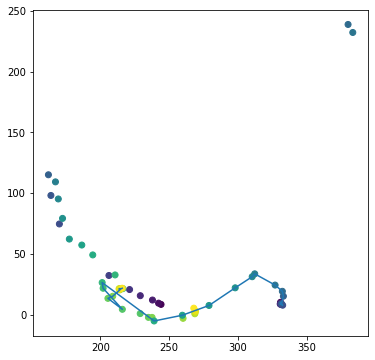

In [198]:
f, ax = plt.subplots(figsize=(6, 6))

file = './grooming/4DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv'

df = pd.read_csv(file, header=[1,2])

x_1 = df['handdx']['x'].values
y_1 = df['handdx']['y'].values

x_2 = df['handsx']['x'].values
y_2 = df['handsx']['y'].values

start_index = 186
end_index = 213
ax.scatter(x_1[start_index:end_index], 500-y_1[start_index:end_index], c=np.arange(end_index - start_index))
ax.scatter(x_2[start_index:end_index], 500-y_2[start_index:end_index], c=np.arange(end_index - start_index))
ax.plot(x_2[start_index:end_index],500-y_2[start_index:end_index])

Text(0.5, 0, 'dorsal-ventral axis [px]')

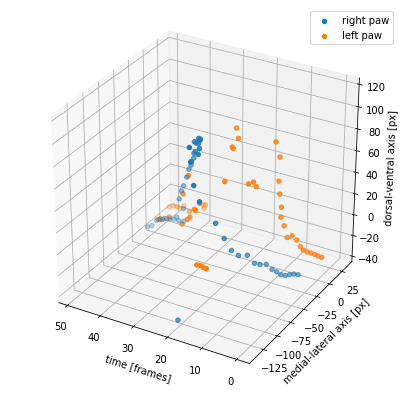

In [98]:
file = './grooming/sDeepCut_resnet50_groomingMar5shuffle1_600000.csv'

df = pd.read_csv(file, header=[1,2])

#remove_2 = [59 + 250]
#remove_1=[68 + 250]

x_1 = df['handdx']['x'].values
y_1 = baseline_subtract(df['handdx']['y'].values)

# x_1 = np.delete(x_1, remove_1)
# y_1 = np.delete(y_1, remove_1)

x_2 = df['handsx']['x'].values
y_2 = baseline_subtract(df['handsx']['y'].values)

# x_2 = np.delete(x_2, remove_2)
# y_2 = np.delete(y_2, remove_2)

x_centroid = np.mean(np.vstack([x_1[::50], x_2[::50]]))
x_1 -= x_centroid
x_2 -= x_centroid

start_index = 960
end_index = 1010

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    xs=np.arange(end_index - start_index),
    ys=x_1[start_index:end_index],
    zs=y_1[start_index:end_index],
    label='right paw'
)


ax.scatter(
    xs=np.arange(end_index - start_index),
    ys=x_2[start_index:end_index],
    zs=y_2[start_index:end_index],
    label='left paw'
)



ax.invert_xaxis()

plt.legend();

ax.set_xlabel('time [frames]')
ax.set_ylabel('medial-lateral axis [px]')
ax.set_zlabel('dorsal-ventral axis [px]')

#fig.savefig('grooming_g_whole_groom.pdf', bbox_inches='tight')
#fig.savefig('grooming_g_whole_groom.png',dpi=300, bbox_inches='tight')

Text(0.5, 0, 'dorsal-ventral axis [px]')

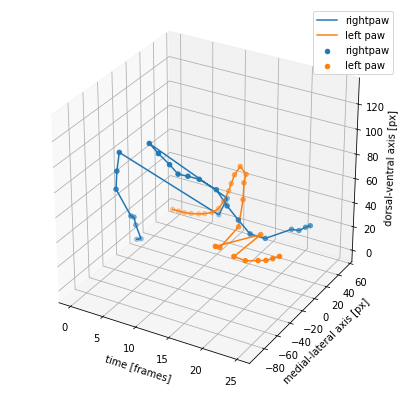

In [412]:
file = './grooming/10DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv'

df = pd.read_csv(file, header=[1,2])

remove_2 = [59 + 250]
remove_1=[68 + 250]

x_1 = df['handdx']['x'].values
y_1 = baseline_subtract(df['handdx']['y'].values)

# x_1 = np.delete(x_1, remove_1)
# y_1 = np.delete(y_1, remove_1)

x_2 = df['handsx']['x'].values
y_2 = baseline_subtract(df['handsx']['y'].values)

# x_2 = np.delete(x_2, remove_2)
# y_2 = np.delete(y_2, remove_2)

x_centroid = np.mean(np.vstack([x_1[::50], x_2[::50]]))
x_1 -= x_centroid
x_2 -= x_centroid

start_index = 192
end_index = 218

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    xs=np.arange(end_index - start_index),
    ys=x_1[start_index:end_index],
    zs=y_1[start_index:end_index],
    label='rightpaw',
)


ax.scatter(
    xs=np.arange(end_index - start_index),
    ys=x_2[start_index:end_index],
    zs=y_2[start_index:end_index],
    label='left paw',
)

ax.plot(
    xs=np.arange(end_index - start_index),
    ys=x_1[start_index:end_index],
    zs=y_1[start_index:end_index],
    label='rightpaw',
)


ax.plot(
    xs=np.arange(end_index - start_index),
    ys=x_2[start_index:end_index],
    zs=y_2[start_index:end_index],
    label='left paw',
)


plt.legend()


ax.set_xlabel('time [frames]')
ax.set_ylabel('medial-lateral axis [px]')
ax.set_zlabel('dorsal-ventral axis [px]')

# fig.savefig('grooming_g_single_groom.pdf', bbox_inches='tight')
# fig.savefig('grooming_g_single_groom.png',dpi=300, bbox_inches='tight')

Text(0.5, 0, 'dorsal-ventral axis [px]')

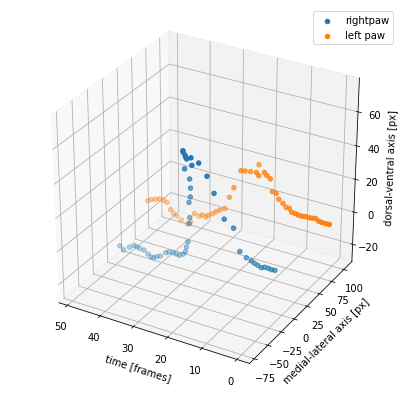

In [198]:
file = './grooming/gDeepCut_resnet50_groomingMar5shuffle1_600000.csv'

df = pd.read_csv(file, header=[1,2])

remove_2 = [59 + 250]
remove_1=[68 + 250]

x_1 = df['handdx']['x'].values
y_1 = baseline_subtract(df['handdx']['y'].values)

# x_1 = np.delete(x_1, remove_1)
# y_1 = np.delete(y_1, remove_1)

x_2 = df['handsx']['x'].values
y_2 = baseline_subtract(df['handsx']['y'].values)

# x_2 = np.delete(x_2, remove_2)
# y_2 = np.delete(y_2, remove_2)

x_centroid = np.mean(np.vstack([x_1[::50], x_2[::50]]))
x_1 -= x_centroid
x_2 -= x_centroid

start_index = 40
end_index = 90

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    xs=np.arange(end_index - start_index),
    ys=x_1[start_index:end_index],
    zs=y_1[start_index:end_index],
    label='rightpaw',
)


ax.scatter(
    xs=np.arange(end_index - start_index),
    ys=x_2[start_index:end_index],
    zs=y_2[start_index:end_index],
    label='left paw',
)


plt.legend()
ax.invert_xaxis()

ax.set_xlabel('time [frames]')
ax.set_ylabel('medial-lateral axis [px]')
ax.set_zlabel('dorsal-ventral axis [px]')

Text(0.5, 0, 'dorsal-ventral axis [px]')

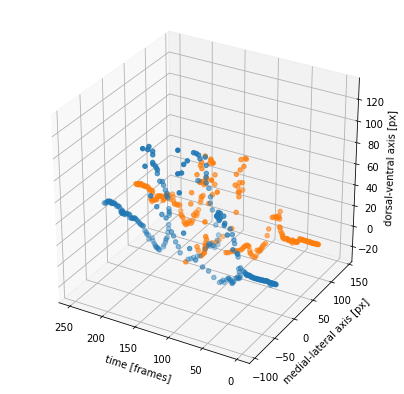

In [111]:
file = './grooming/gDeepCut_resnet50_groomingMar5shuffle1_600000.csv'

df = pd.read_csv(file, header=[1,2])



x_1 = df['handdx']['x'].values
y_1 = baseline_subtract(df['handdx']['y'].values)

x_2 = df['handsx']['x'].values
y_2 = baseline_subtract(df['handsx']['y'].values)

x_centroid = np.mean(np.vstack([x_1[::50], x_2[::50]]))
x_1 -= x_centroid
x_2 -= x_centroid

start_index = 0
end_index = 250

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    xs=np.arange(end_index - start_index),
    ys=x_1[start_index:end_index],
    zs=y_1[start_index:end_index],
)


ax.scatter(
    xs=np.arange(end_index - start_index),
    ys=x_2[start_index:end_index],
    zs=y_2[start_index:end_index],
)



ax.invert_xaxis()

ax.set_xlabel('time [frames]')
ax.set_ylabel('medial-lateral axis [px]')
ax.set_zlabel('dorsal-ventral axis [px]')

Text(0.5, 0, 'dorsal-ventral axis [px]')

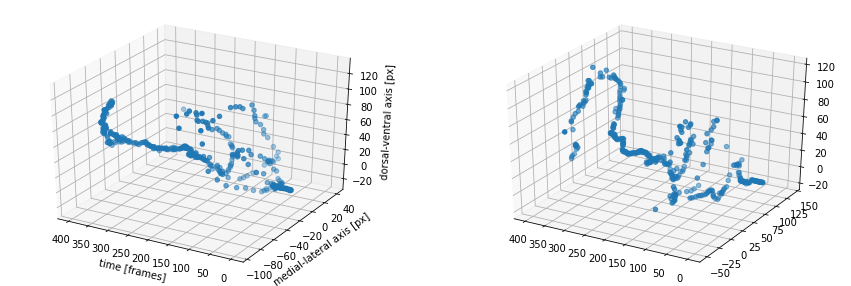

In [108]:
file = './grooming/gDeepCut_resnet50_groomingMar5shuffle1_600000.csv'

df = pd.read_csv(file, header=[1,2])



x_1 = df['handdx']['x'].values
y_1 = baseline_subtract(df['handdx']['y'].values)

x_2 = df['handsx']['x'].values
y_2 = baseline_subtract(df['handsx']['y'].values)

x_centroid = np.mean(np.vstack([x_1[::50], x_2[::50]]))
x_1 -= x_centroid
x_2 -= x_centroid

start_index = 0
end_index = 400

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121, projection='3d')

ax1.scatter(
    xs=np.arange(end_index - start_index),
    ys=x_1[start_index:end_index],
    zs=y_1[start_index:end_index],
)

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(
    xs=np.arange(end_index - start_index),
    ys=x_2[start_index:end_index],
    zs=y_2[start_index:end_index],
)



ax1.invert_xaxis()
ax2.invert_xaxis()

ax1.set_xlabel('time [frames]')
ax1.set_ylabel('medial-lateral axis [px]')
ax1.set_zlabel('dorsal-ventral axis [px]')

In [234]:
t, p = stats.ttest_rel(merged_grooming['total_path_length_s'].values, merged_grooming['total_path_length_d'])

fold_change = np.mean(np.divide(merged_grooming['total_path_length_s'].values, merged_grooming['total_path_length_d']))

print(f'handsx is {fold_change:1.2} times greater than handdx, p={p}, n={len(merged_grooming)}')

handsx is 2.0 times greater than handdx, p=0.012331417794000684, n=51


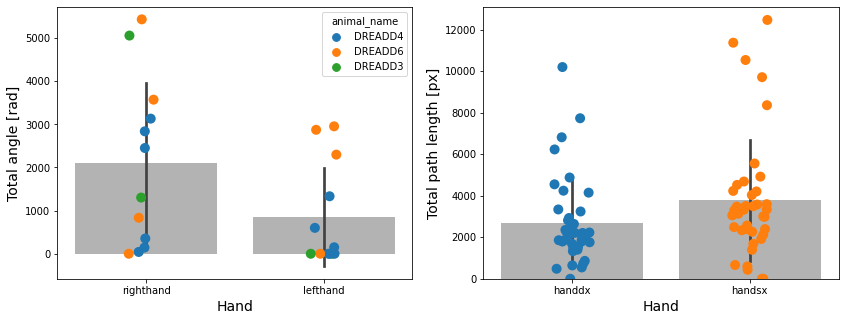

In [31]:
f, ax  = plt.subplots(1, 2, figsize=(14, 5))

a = ax[0]
a = sns.barplot(x='hand', y='total_path_length', ci='sd', data=grooming_df_nat, ax=a, color=[0.7, 0.7, 0.7, 1])
a = sns.stripplot(x='hand', y='total_path_length', hue='animal_name', data=grooming_df_nat, ax=a, size=10)

a.set_xlabel('Hand', fontsize=14)
a.set_ylabel('Total angle [rad]', fontsize=14)

b = ax[1]
b = sns.barplot(x='hand', y='total_path_length', ci='sd', data=grooming_df_opto, ax=b, color=[0.7, 0.7, 0.7, 1])
b = sns.stripplot(x='hand', y='total_path_length', data=grooming_df_opto, ax=b, size=10)

b.set_xlabel('Hand', fontsize=14)
b.set_ylabel('Total path length [px]', fontsize=14)


f.savefig('grooming.png', dpi=300, bbox_inches='tight')

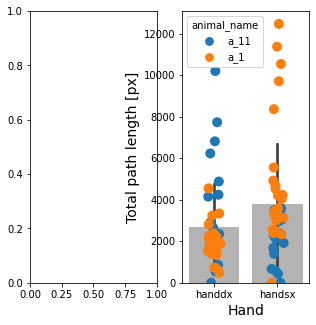

In [26]:
f, ax = plt.subplots(1, 2, figsize=(5, 5))

a = ax[0]
a = sns.barplot(x='hand', y='total_path_length', ci='sd', data=grooming_df_nat, ax=b, color=[0.7, 0.7, 0.7, 1])
a = sns.stripplot(x='hand', y='total_path_length', hue='animal_name', data=grooming_df_nat, ax=b, size=10)

a.set_xlabel('Hand', fontsize=14)
a.set_ylabel('Total path length [px]', fontsize=14)

b = ax[1]
b = sns.barplot(x='hand', y='total_path_length', ci='sd', data=grooming_df_opto, ax=b, color=[0.7, 0.7, 0.7, 1])
b = sns.stripplot(x='hand', y='total_path_length', hue='animal_name', data=grooming_df_opto, ax=b, size=10)

b.set_xlabel('Hand', fontsize=14)
b.set_ylabel('Total path length [px]', fontsize=14)

f.savefig('grooming_path_length.png', dpi=300, bbox_inches='tight')
f.savefig('grooming_path_length.pdf', dpi=300, bbox_inches='tight')

In [ ]:
# merged_grooming = d.merge(s, on='file', suffixes=('_d','_s'))

# s_0 = merged_grooming['total_path_length_s'] == 0
# d_0 = merged_grooming['total_path_length_d'] == 0

# not_0 = np.logical_not(np.logical_or(s_0, d_0))

# merged_grooming = merged_grooming.loc[not_0]

# t, p = stats.ttest_rel(merged_grooming['total_path_length_s'].values, merged_grooming['total_path_length_d'])

# fold_change = np.mean(np.divide(merged_grooming['total_path_length_s'].values, merged_grooming['total_path_length_d']))

# print(f'handsx is {fold_change:1.2} times greater than handdx, p={p}, n={len(merged_grooming)}')

# Grooming traces

In [366]:
grooming_trace_files_df = pd.read_csv('./grooming/grooming_frames.csv')

In [543]:
x = []
y = []
t = []
t_norm = []

hand = []
trace_type = []
animal_name = []
file_name = []
mirrored = True
x_centering_centroid = True

for i, row in grooming_trace_files_df.iterrows():
    # load the tracking data
    f_name = row['file']
    df = pd.read_csv(f_name, header=[1,2])
    
    if mirrored:
        left_offset = 50
        right_offset = -50
    else:
        left_offset = -50
        right_offset = 50

    x_1 = -1 * baseline_subtract(df['handdx']['x'].values)
    y_1 = baseline_subtract(df['handdx']['y'].values)
    right_likelihood = df['handdx']['likelihood'].values

    x_2 = -1 * baseline_subtract(df['handsx']['x'].values)
    y_2 = baseline_subtract(df['handsx']['y'].values)
    left_likelihood = df['handsx']['likelihood'].values

    #full trace
#     full_trace_start = row['groom_start']
#     full_trace_end = row['groom_end']
#     n_frames_full = full_trace_end - full_trace_start
    
#     x += list(x_1[full_trace_start:full_trace_end])
#     y += list(y_1[full_trace_start:full_trace_end])
#     t += list(np.arange(n_frames_full))
#     hand += n_frames_full * ['right']
#     animal_name += n_frames_full * [row['animal']]
#     file_name += n_frames_full * [f_name]
#     trace_type += n_frames_full * ['full']
    
#     x += list(x_2[full_trace_start:full_trace_end])
#     y += list(y_2[full_trace_start:full_trace_end])
#     t += list(np.arange(n_frames_full))
#     hand += n_frames_full * ['left']
#     animal_name += n_frames_full * [row['animal']]
#     file_name += n_frames_full * [f_name]
#     trace_type += n_frames_full * ['full']
    
    # single_trace
    single_trace_start = row['single_start']
    single_trace_end = row['single_end']
    n_frames_single = single_trace_end - single_trace_start
    
    x_1_single = x_1[single_trace_start:single_trace_end]
    y_1_single = y_1[single_trace_start:single_trace_end]
    
    x_2_single = x_2[single_trace_start:single_trace_end]
    y_2_single = y_2[single_trace_start:single_trace_end]
    
    if x_centering_centroid:
        x_centroid = np.mean(np.concatenate([x_1_single[0:2], x_2_single[0:2]]))
        x_1_single -= x_centroid
        x_2_single -= x_centroid
    else:
        x_1_single += right_offset
        x_2_single += left_offset
    
    
    t_single = np.arange(n_frames_single)
    t_single_norm = t_single / len(t_single)

    likelihood_thresh = 0.8
    
    right_likelihood_single = right_likelihood[single_trace_start:single_trace_end]
    good_points_right = right_likelihood_single > likelihood_thresh
    
    left_likelihood_single = left_likelihood[single_trace_start:single_trace_end]
    good_points_left = left_likelihood_single > likelihood_thresh
    
    good_points = np.logical_and(good_points_right, good_points_left)
    
    x_1_single = x_1_single[good_points]
    y_1_single = y_1_single[good_points]
    x_2_single = x_2_single[good_points]
    y_2_single = y_2_single[good_points]
    t_single = t_single[good_points]
    t_single_norm = t_single_norm[good_points]
    
    n_frames_single = len(x_1_single)
    
    x += list(x_1_single)
    y += list(y_1_single)
    t += list(t_single)
    t_norm += list(t_single_norm)
    hand += n_frames_single * ['right']
    animal_name += n_frames_single * [row['animal']]
    file_name += n_frames_single * [f_name]
    trace_type += n_frames_single * ['single']
    
    x += list(x_2_single)
    y += list(y_2_single)
    t += list(t_single)
    t_norm += list(t_single_norm)
    hand += n_frames_single * ['left']
    animal_name += n_frames_single * [row['animal']]
    file_name += n_frames_single * [f_name]
    trace_type += n_frames_single * ['single']
    
grooming_traces_df = pd.DataFrame(
    {
        'animal_name': animal_name,
        'file_name': file_name,
        'trace_type': trace_type,
        'hand': hand,
        'x': x,
        'y': y,
        't': t,
        't_norm': t_norm
    }
)

1168
1168
1168
1168
1168
1168


In [544]:
x_1_single[0:3]

array([ 0.16059952, -0.86662216, -8.13767929])

In [545]:
grooming_traces_df.head()

,animal_name,file_name,trace_type,hand,x,y,t,t_norm
0,a1,./grooming/gDeepCut_resnet50_groomingMar5shuff...,single,right,1.568568,0.956949,0,0.00
1,a1,./grooming/gDeepCut_resnet50_groomingMar5shuff...,single,right,1.950989,0.690746,1,0.02
2,a1,./grooming/gDeepCut_resnet50_groomingMar5shuff...,single,right,2.214338,0.779124,2,0.04
3,a1,./grooming/gDeepCut_resnet50_groomingMar5shuff...,single,right,1.958200,0.899562,3,0.06
4,a1,./grooming/gDeepCut_resnet50_groomingMar5shuff...,single,right,2.296047,-0.103875,4,0.08


In [582]:
#     
# bins = np.linspace(0, 1, 16)
# df['t_norm_bin'] = df.apply(lambda row: np.digitize(row['t_norm'], bins, right=False), axis=1)

bins = np.linspace(0, 1, 10)
t_norm = grooming_traces_df['t_norm'].values
t_bin = np.digitize(t_norm, bins=bins)
t_bin[t_norm == 0] = 0

n_bins = len(np.unique(t_bin))
t_bin_normed = t_bin / (n_bins - 1)

grooming_traces_df['t_bin'] = t_bin
grooming_traces_df['t_bin_normed'] = t_bin_normed


In [583]:
grooming_traces_binned = grooming_traces_df.groupby(['animal_name', 'file_name','trace_type','hand', 't_bin_normed']).mean().reset_index()

/Users/yamauc0000/Documents/PoseProcessor/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


['./grooming/rDeepCut_resnet50_groomingMar5shuffle1_600000.csv', './grooming/hDeepCut_resnet50_groomingMar5shuffle1_600000.csv', './grooming/qDeepCut_resnet50_groomingMar5shuffle1_600000.csv', './grooming/sDeepCut_resnet50_groomingMar5shuffle1_600000.csv', './grooming/yDeepCut_resnet50_groomingMar5shuffle1_600000.csv']


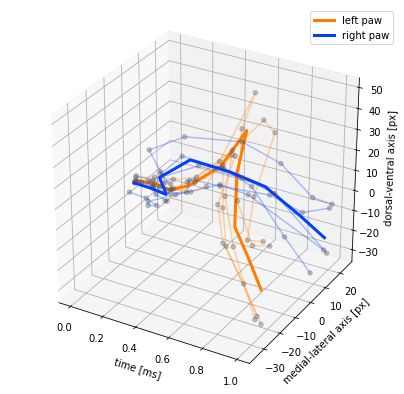

In [584]:
is_mirrored = False
reversed_time = False

#for n_files in [3, 5, 7, 9]:
for n_files in [5]:

    trace_type = 'single'
    a = 'a1'
    animal_df = grooming_traces_binned.loc[
        (grooming_traces_binned['animal_name'] == a) &
        (grooming_traces_binned['trace_type'] == 'single')
    ]

    animal_df['t_ms'] = animal_df['t'] * (1/619) * 1000

    
    # get the rows from just the number of files
    files_to_use = [
    './grooming/rDeepCut_resnet50_groomingMar5shuffle1_600000.csv',
     './grooming/hDeepCut_resnet50_groomingMar5shuffle1_600000.csv',
     './grooming/qDeepCut_resnet50_groomingMar5shuffle1_600000.csv',
     './grooming/sDeepCut_resnet50_groomingMar5shuffle1_600000.csv',
     './grooming/yDeepCut_resnet50_groomingMar5shuffle1_600000.csv'
    ]

    print(files_to_use)
    animal_df = animal_df.loc[animal_df.file_name.isin(files_to_use)]

    colors = sns.color_palette('bright')
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')

    for file in files_to_use:


        df = animal_df.loc[animal_df['file_name'] == file]
        
        ax.scatter(
            xs=df.loc[df['hand'] == 'left']['t_bin_normed'],
            ys=df.loc[df['hand'] == 'left']['x'],
            zs=df.loc[df['hand'] == 'left']['y'],
            color=[0.3, 0.3, 0.3],
            alpha=0.3,
            zorder=1
        )
        ax.plot(
            xs=df.loc[df['hand'] == 'left']['t_bin_normed'],
            ys=df.loc[df['hand'] == 'left']['x'],
            zs=df.loc[df['hand'] == 'left']['y'],
            color=colors[1],
            alpha=0.3,
            zorder=2
        )
        
        ax.scatter(
            xs=df.loc[df['hand'] == 'right']['t_bin_normed'],
            ys=df.loc[df['hand'] == 'right']['x'],
            zs=df.loc[df['hand'] == 'right']['y'],
            color=[0.3, 0.3, 0.3],
            alpha=0.3,
            zorder = 7
        )
        ax.plot(
            xs=df.loc[df['hand'] == 'right']['t_bin_normed'],
            ys=df.loc[df['hand'] == 'right']['x'],
            zs=df.loc[df['hand'] == 'right']['y'],
            color=colors[0],
            alpha=0.3,
            zorder=8
        )

    means = animal_df.groupby(['t_bin_normed', 'hand']).mean().reset_index()

    ax.plot(
        xs=means.loc[means['hand'] == 'left']['t_bin_normed'],
        ys=means.loc[means['hand'] == 'left']['x'],
        zs=means.loc[means['hand'] == 'left']['y'],
        color=colors[1],
        alpha=1,
        linewidth=3,
        label='left paw',
        zorder=3
    )
    
    ax.plot(
        xs=means.loc[means['hand'] == 'right']['t_bin_normed'],
        ys=means.loc[means['hand'] == 'right']['x'],
        zs=means.loc[means['hand'] == 'right']['y'],
        color=colors[0],
        alpha=1,
        linewidth=3,
        label='right paw',
        zorder=9
    )


    ax.set_xlabel('time [ms]')
    ax.set_ylabel('medial-lateral axis [px]')
    ax.set_zlabel('dorsal-ventral axis [px]')

    plt.legend()

    if is_mirrored:
        mirror_name = 'mirrored'
    else:
        mirror_name = 'not_mirrored'
    
    if reversed_time:
        ax.invert_xaxis()
        time_name = 'reversed_time'
    else:
        time_name = 'not_reversed_time'
        
    if x_centering_centroid:
        centering_name = 'centroid'
    else:
        centering_name = 'offset'
    
    im_file_base = f'grooming_trace_{a}_{n_files}_trials_{mirror_name}_{time_name}_{centering_name}'
    
    
    fig.savefig(im_file_base + '.pdf', bbox_inches='tight')
    fig.savefig(im_file_base + '.png',dpi=300, bbox_inches='tight')

/Users/yamauc0000/Documents/PoseProcessor/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


['./grooming/3DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv', './grooming/5DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv', './grooming/12DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv', './grooming/8DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv', './grooming/17DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv']


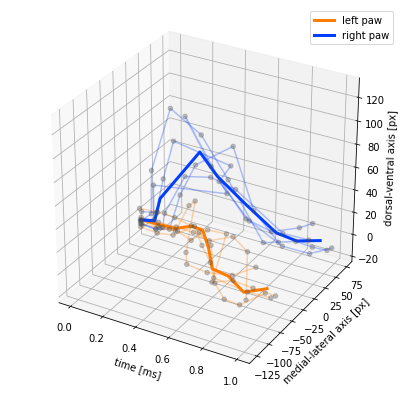

In [585]:
is_mirrored = False
reversed_time = False

#for n_files in [3, 5, 7, 9]:
for n_files in [5]:

    trace_type = 'single'
    a = 'a11'
    animal_df = grooming_traces_binned.loc[
        (grooming_traces_binned['animal_name'] == a) &
        (grooming_traces_binned['trace_type'] == 'single')
    ]

    animal_df['t_ms'] = animal_df['t'] * (1/619) * 1000

    
    # get the rows from just the number of files
    files_to_use = [
        './grooming/3DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv',
         './grooming/5DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv',
        './grooming/12DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv',
        './grooming/8DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv',
         './grooming/17DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv'
    ]

    print(files_to_use)
    animal_df = animal_df.loc[animal_df.file_name.isin(files_to_use)]

    colors = sns.color_palette('bright')
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')

    for file in files_to_use:


        df = animal_df.loc[animal_df['file_name'] == file]

        ax.scatter(
            xs=df.loc[df['hand'] == 'left']['t_bin_normed'],
            ys=df.loc[df['hand'] == 'left']['x'],
            zs=df.loc[df['hand'] == 'left']['y'],
            color=[0.3, 0.3, 0.3],
            alpha=0.3
        )
        ax.plot(
            xs=df.loc[df['hand'] == 'left']['t_bin_normed'],
            ys=df.loc[df['hand'] == 'left']['x'],
            zs=df.loc[df['hand'] == 'left']['y'],
            color=colors[1],
            alpha=0.3
        )
        
        ax.scatter(
            xs=df.loc[df['hand'] == 'right']['t_bin_normed'],
            ys=df.loc[df['hand'] == 'right']['x'],
            zs=df.loc[df['hand'] == 'right']['y'],
            color=[0.3, 0.3, 0.3],
            alpha=0.3
        )
        ax.plot(
            xs=df.loc[df['hand'] == 'right']['t_bin_normed'],
            ys=df.loc[df['hand'] == 'right']['x'],
            zs=df.loc[df['hand'] == 'right']['y'],
            color=colors[0],
            alpha=0.3
        )

    means = animal_df.groupby(['t_bin_normed', 'hand']).mean().reset_index()

    ax.plot(
        xs=means.loc[means['hand'] == 'left']['t_bin_normed'],
        ys=means.loc[means['hand'] == 'left']['x'],
        zs=means.loc[means['hand'] == 'left']['y'],
        color=colors[1],
        alpha=1,
        linewidth=3,
        label='left paw'
    )
    
    ax.plot(
        xs=means.loc[means['hand'] == 'right']['t_bin_normed'],
        ys=means.loc[means['hand'] == 'right']['x'],
        zs=means.loc[means['hand'] == 'right']['y'],
        color=colors[0],
        alpha=1,
        linewidth=3,
        label='right paw'
    )


    ax.set_xlabel('time [ms]')
    ax.set_ylabel('medial-lateral axis [px]')
    ax.set_zlabel('dorsal-ventral axis [px]')

    plt.legend()

    if is_mirrored:
        mirror_name = 'mirrored'
    else:
        mirror_name = 'not_mirrored'
    
    if reversed_time:
        ax.invert_xaxis()
        time_name = 'reversed_time'
    else:
        time_name = 'not_reversed_time'
        
    if x_centering_centroid:
        centering_name = 'centroid'
    else:
        centering_name = 'offset'
    
    im_file_base = f'grooming_trace_{a}_{n_files}_trials_{mirror_name}_{time_name}_{centering_name}'
    
    
    fig.savefig(im_file_base + '.pdf', bbox_inches='tight')
    fig.savefig(im_file_base + '.png',dpi=300, bbox_inches='tight')

/Users/yamauc0000/Documents/PoseProcessor/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yamauc0000/Documents/PoseProcessor/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


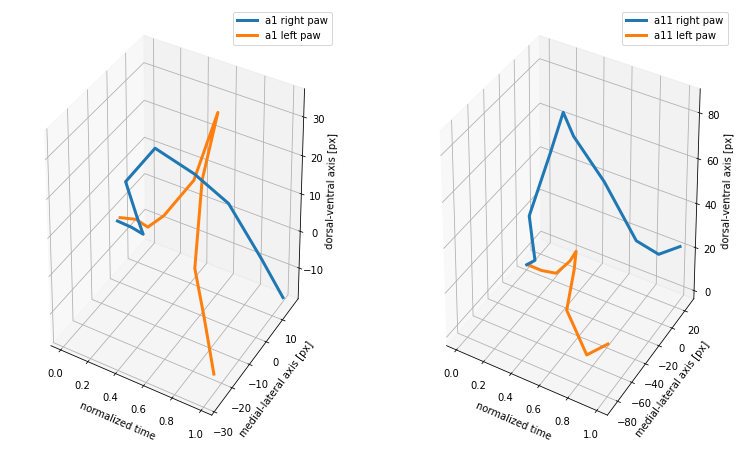

In [591]:
for n_files in [5]:
    colors = sns.color_palette('bright')
    fig = plt.figure(figsize=(13, 8))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    axs = [ax1, ax2]
    
    good_files = {
        'a1': [
            './grooming/rDeepCut_resnet50_groomingMar5shuffle1_600000.csv',
             './grooming/hDeepCut_resnet50_groomingMar5shuffle1_600000.csv',
             './grooming/qDeepCut_resnet50_groomingMar5shuffle1_600000.csv',
             './grooming/sDeepCut_resnet50_groomingMar5shuffle1_600000.csv',
             './grooming/yDeepCut_resnet50_groomingMar5shuffle1_600000.csv'
        ],
        'a11': [
            './grooming/3DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv',
             './grooming/5DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv',
             './grooming/8DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv',
             './grooming/10DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv',
             './grooming/17DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv'
        ]
    }
    
    for i, a in enumerate(['a1', 'a11']):
        
        ax = axs[i]

        trace_type = 'single'

        animal_df = grooming_traces_binned.loc[
            (grooming_traces_binned['animal_name'] == a) &
            (grooming_traces_binned['trace_type'] == 'single')
        ]

        animal_df['t_ms'] = animal_df['t'] * (1/619) * 1000

        # get the rows from just the number of files
        files_to_use = good_files[a]
        animal_df = animal_df.loc[animal_df.file_name.isin(files_to_use)]

        means = animal_df.groupby(['t_bin_normed', 'hand']).mean().reset_index()

        ax.plot(
            xs=means.loc[means['hand'] == 'right']['t_bin_normed'],
            ys=means.loc[means['hand'] == 'right']['x'],
            zs=means.loc[means['hand'] == 'right']['y'],
            alpha=1,
            linewidth=3,
            label=f'{a} right paw',
            zorder=9
        )

        ax.plot(
            xs=means.loc[means['hand'] == 'left']['t_bin_normed'],
            ys=means.loc[means['hand'] == 'left']['x'],
            zs=means.loc[means['hand'] == 'left']['y'],
            alpha=1,
            linewidth=3,
            label=f'{a} left paw',
            zorder=4
        )

        ax.set_xlabel('normalized time')
        ax.set_ylabel('medial-lateral axis [px]')
        ax.set_zlabel('dorsal-ventral axis [px]')
            
        if reversed_time:
            ax.invert_xaxis()
            time_name = 'reversed_time'
        else:
            time_name = 'not_reversed_time'

        ax.legend()

    if is_mirrored:
        mirror_name = 'mirrored'
    else:
        mirror_name = 'not_mirrored'
        
    if x_centering_centroid:
        centering_name = 'centroid'
    else:
        centering_name = 'offset'

    
    im_file_base = f'grooming_trace_all_animals_2_plots_{n_files}_trials_{mirror_name}_{time_name}_{centering_name}'
    
    
    fig.savefig(im_file_base + '.pdf', bbox_inches='tight')
    fig.savefig(im_file_base + '.png',dpi=300, bbox_inches='tight')

/Users/yamauc0000/Documents/PoseProcessor/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yamauc0000/Documents/PoseProcessor/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


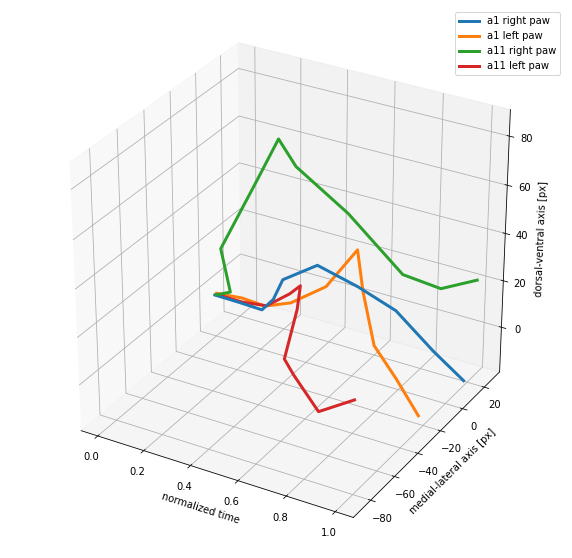

In [592]:
for n_files in [5]:
    colors = sns.color_palette('bright')
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    good_files = {
        'a1': [
            './grooming/rDeepCut_resnet50_groomingMar5shuffle1_600000.csv',
             './grooming/hDeepCut_resnet50_groomingMar5shuffle1_600000.csv',
             './grooming/qDeepCut_resnet50_groomingMar5shuffle1_600000.csv',
             './grooming/sDeepCut_resnet50_groomingMar5shuffle1_600000.csv',
             './grooming/yDeepCut_resnet50_groomingMar5shuffle1_600000.csv'
        ],
        'a11': [
            './grooming/3DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv',
             './grooming/5DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv',
             './grooming/8DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv',
             './grooming/10DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv',
             './grooming/17DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv'
        ]
    }
    
    for i, a in enumerate(['a1', 'a11']):
        
        trace_type = 'single'

        animal_df = grooming_traces_binned.loc[
            (grooming_traces_binned['animal_name'] == a) &
            (grooming_traces_binned['trace_type'] == 'single')
        ]

        animal_df['t_ms'] = animal_df['t'] * (1/619) * 1000

        # get the rows from just the number of files
        files_to_use = good_files[a]
        animal_df = animal_df.loc[animal_df.file_name.isin(files_to_use)]

        means = animal_df.groupby(['t_bin_normed', 'hand']).mean().reset_index()

        ax.plot(
            xs=means.loc[means['hand'] == 'right']['t_bin_normed'],
            ys=means.loc[means['hand'] == 'right']['x'],
            zs=means.loc[means['hand'] == 'right']['y'],
            alpha=1,
            linewidth=3,
            label=f'{a} right paw',
            zorder=9
        )

        ax.plot(
            xs=means.loc[means['hand'] == 'left']['t_bin_normed'],
            ys=means.loc[means['hand'] == 'left']['x'],
            zs=means.loc[means['hand'] == 'left']['y'],
            alpha=1,
            linewidth=3,
            label=f'{a} left paw',
            zorder=1,
        )

        ax.set_xlabel('normalized time')
        ax.set_ylabel('medial-lateral axis [px]')
        ax.set_zlabel('dorsal-ventral axis [px]')
            
        if reversed_time:
            ax.invert_xaxis()
            time_name = 'reversed_time'
        else:
            time_name = 'not_reversed_time'

        ax.legend()

    if is_mirrored:
        mirror_name = 'mirrored'
    else:
        mirror_name = 'not_mirrored'
        
    if x_centering_centroid:
        centering_name = 'centroid'
    else:
        centering_name = 'offset'

    
    im_file_base = f'grooming_trace_all_animals_1_plot_{n_files}_trials_{mirror_name}_{time_name}_{centering_name}'
    
    
    fig.savefig(im_file_base + '.pdf', bbox_inches='tight')
    fig.savefig(im_file_base + '.png',dpi=300, bbox_inches='tight')

/Users/yamauc0000/Documents/PoseProcessor/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


['./grooming/rDeepCut_resnet50_groomingMar5shuffle1_600000.csv', './grooming/hDeepCut_resnet50_groomingMar5shuffle1_600000.csv', './grooming/qDeepCut_resnet50_groomingMar5shuffle1_600000.csv', './grooming/sDeepCut_resnet50_groomingMar5shuffle1_600000.csv', './grooming/yDeepCut_resnet50_groomingMar5shuffle1_600000.csv']


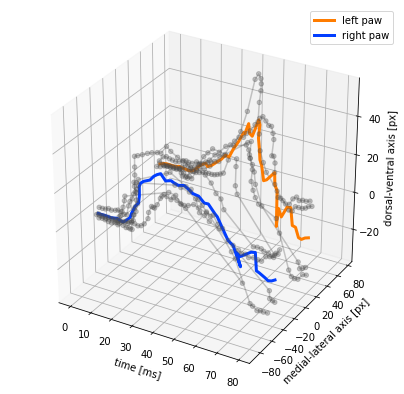

In [444]:
# unbinned plots a1

# is_mirrored = False
# reversed_time = False

# #for n_files in [3, 5, 7, 9]:
# for n_files in [5]:

#     trace_type = 'single'
#     a = 'a1'
#     animal_df = grooming_traces_df.loc[
#         (grooming_traces_df['animal_name'] == a) &
#         (grooming_traces_df['trace_type'] == 'single')
#     ]

#     animal_df['t_ms'] = animal_df['t'] * (1/619) * 1000

    
#     # get the rows from just the number of files
#     files_to_use = [
#     './grooming/rDeepCut_resnet50_groomingMar5shuffle1_600000.csv',
#      './grooming/hDeepCut_resnet50_groomingMar5shuffle1_600000.csv',
#      './grooming/qDeepCut_resnet50_groomingMar5shuffle1_600000.csv',
#      './grooming/sDeepCut_resnet50_groomingMar5shuffle1_600000.csv',
#      './grooming/yDeepCut_resnet50_groomingMar5shuffle1_600000.csv'
#     ]

#     print(files_to_use)
#     animal_df = animal_df.loc[animal_df.file_name.isin(files_to_use)]

#     colors = sns.color_palette('bright')
#     fig = plt.figure(figsize=(7, 7))
#     ax = fig.add_subplot(111, projection='3d')

#     for file in files_to_use:


#         df = animal_df.loc[animal_df['file_name'] == file]

#         ax.scatter(
#             xs=df.loc[df['hand'] == 'left']['t_ms'],
#             ys=df.loc[df['hand'] == 'left']['x'],
#             zs=df.loc[df['hand'] == 'left']['y'],
#             color=[0.3, 0.3, 0.3],
#             alpha=0.3
#         )
#         ax.plot(
#             xs=df.loc[df['hand'] == 'left']['t_ms'],
#             ys=df.loc[df['hand'] == 'left']['x'],
#             zs=df.loc[df['hand'] == 'left']['y'],
#             color=[0.3, 0.3, 0.3],
#             alpha=0.3
#         )
        
#         ax.scatter(
#             xs=df.loc[df['hand'] == 'right']['t_ms'],
#             ys=df.loc[df['hand'] == 'right']['x'],
#             zs=df.loc[df['hand'] == 'right']['y'],
#             color=[0.3, 0.3, 0.3],
#             alpha=0.3
#         )
#         ax.plot(
#             xs=df.loc[df['hand'] == 'right']['t_ms'],
#             ys=df.loc[df['hand'] == 'right']['x'],
#             zs=df.loc[df['hand'] == 'right']['y'],
#             color=[0.3, 0.3, 0.3],
#             alpha=0.3
#         )

#     means = animal_df.groupby(['t', 'hand']).mean().reset_index()

#     ax.plot(
#         xs=means.loc[means['hand'] == 'left']['t_ms'],
#         ys=means.loc[means['hand'] == 'left']['x'],
#         zs=means.loc[means['hand'] == 'left']['y'],
#         color=colors[1],
#         alpha=1,
#         linewidth=3,
#         label='left paw'
#     )
    
#     ax.plot(
#         xs=means.loc[means['hand'] == 'right']['t_ms'],
#         ys=means.loc[means['hand'] == 'right']['x'],
#         zs=means.loc[means['hand'] == 'right']['y'],
#         color=colors[0],
#         alpha=1,
#         linewidth=3,
#         label='right paw'
#     )


#     ax.set_xlabel('time [ms]')
#     ax.set_ylabel('medial-lateral axis [px]')
#     ax.set_zlabel('dorsal-ventral axis [px]')

#     plt.legend()

#     if is_mirrored:
#         mirror_name = 'mirrored'
#     else:
#         mirror_name = 'not_mirrored'
    
#     if reversed_time:
#         ax.invert_xaxis()
#         time_name = 'reversed_time'
#     else:
#         time_name = 'not_reversed_time'
    
#     im_file_base = f'grooming_trace_{a}_{n_files}_trials_{mirror_name}_{time_name}'
    
    
#     fig.savefig(im_file_base + '.pdf', bbox_inches='tight')
#     fig.savefig(im_file_base + '.png',dpi=300, bbox_inches='tight')
 

/Users/yamauc0000/Documents/PoseProcessor/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


['./grooming/3DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv'
 './grooming/5DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv'
 './grooming/8DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv'
 './grooming/10DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv'
 './grooming/17DLC_resnet50_Grooming_animal11Apr30shuffle1_650000.csv']


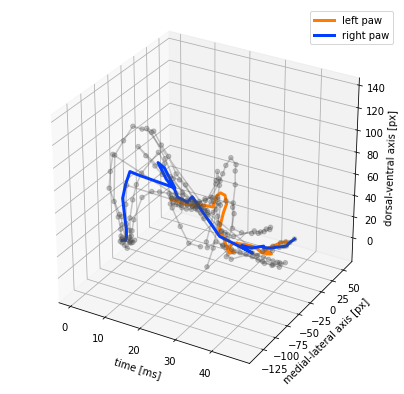

In [411]:
# unbinned plots a11

# is_mirrored = False
# reversed_time = False

# #for n_files in [3, 5, 7, 9]:
# for n_files in [5]:

#     trace_type = 'single'
#     a = 'a11'
#     animal_df = grooming_traces_df.loc[
#         (grooming_traces_df['animal_name'] == a) &
#         (grooming_traces_df['trace_type'] == 'single')
#     ]

#     animal_df['t_ms'] = animal_df['t'] * (1/619) * 1000

    
#     # get the rows from just the number of files
#     files_to_use = animal_df['file_name'].unique()[[0, 2,3,4, 8]]
#     print(files_to_use)
#     animal_df = animal_df.loc[animal_df.file_name.isin(files_to_use)]

#     colors = sns.color_palette('bright')
#     fig = plt.figure(figsize=(7, 7))
#     ax = fig.add_subplot(111, projection='3d')

#     for file in files_to_use:


#         df = animal_df.loc[animal_df['file_name'] == file]

#         ax.scatter(
#             xs=df.loc[df['hand'] == 'left']['t_ms'],
#             ys=df.loc[df['hand'] == 'left']['x'],
#             zs=df.loc[df['hand'] == 'left']['y'],
#             color=[0.3, 0.3, 0.3],
#             alpha=0.3
#         )
#         ax.plot(
#             xs=df.loc[df['hand'] == 'left']['t_ms'],
#             ys=df.loc[df['hand'] == 'left']['x'],
#             zs=df.loc[df['hand'] == 'left']['y'],
#             color=[0.3, 0.3, 0.3],
#             alpha=0.3
#         )
        
#         ax.scatter(
#             xs=df.loc[df['hand'] == 'right']['t_ms'],
#             ys=df.loc[df['hand'] == 'right']['x'],
#             zs=df.loc[df['hand'] == 'right']['y'],
#             color=[0.3, 0.3, 0.3],
#             alpha=0.3
#         )
#         ax.plot(
#             xs=df.loc[df['hand'] == 'right']['t_ms'],
#             ys=df.loc[df['hand'] == 'right']['x'],
#             zs=df.loc[df['hand'] == 'right']['y'],
#             color=[0.3, 0.3, 0.3],
#             alpha=0.3
#         )

#     means = animal_df.groupby(['t', 'hand']).mean().reset_index()

#     ax.plot(
#         xs=means.loc[means['hand'] == 'left']['t_ms'],
#         ys=means.loc[means['hand'] == 'left']['x'],
#         zs=means.loc[means['hand'] == 'left']['y'],
#         color=colors[1],
#         alpha=1,
#         linewidth=3,
#         label='left paw'
#     )
    
#     ax.plot(
#         xs=means.loc[means['hand'] == 'right']['t_ms'],
#         ys=means.loc[means['hand'] == 'right']['x'],
#         zs=means.loc[means['hand'] == 'right']['y'],
#         color=colors[0],
#         alpha=1,
#         linewidth=3,
#         label='right paw'
#     )


#     ax.set_xlabel('time [ms]')
#     ax.set_ylabel('medial-lateral axis [px]')
#     ax.set_zlabel('dorsal-ventral axis [px]')

#     plt.legend()

#     if is_mirrored:
#         mirror_name = 'mirrored'
#     else:
#         mirror_name = 'not_mirrored'
    
#     if reversed_time:
#         ax.invert_xaxis()
#         time_name = 'reversed_time'
#     else:
#         time_name = 'not_reversed_time'
    
#     im_file_base = f'grooming_trace_{a}_{n_files}_trials_{mirror_name}_{time_name}'
    
    
#     fig.savefig(im_file_base + '.pdf', bbox_inches='tight')
#     fig.savefig(im_file_base + '.png',dpi=300, bbox_inches='tight')

/Users/yamauc0000/Documents/PoseProcessor/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yamauc0000/Documents/PoseProcessor/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yamauc0000/Documents/PoseProcessor/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

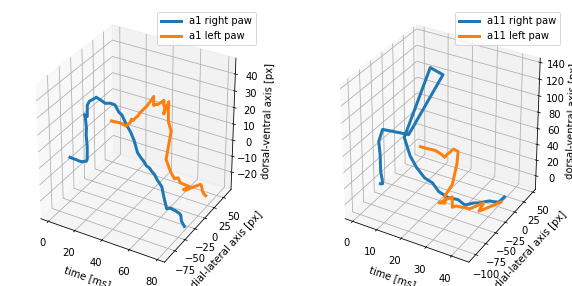

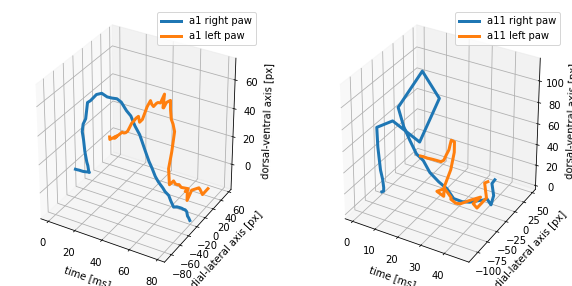

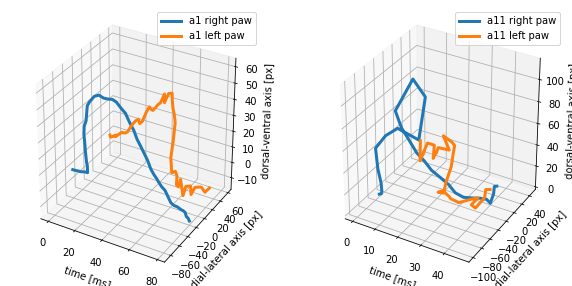

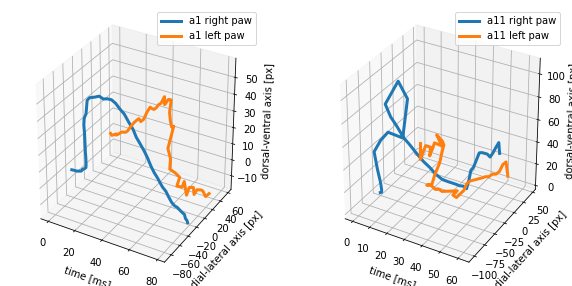

In [172]:
for n_files in [3, 5, 7, 9]:
    colors = sns.color_palette('bright')
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    axs = [ax1, ax2]
    
    for i, a in enumerate(['a1', 'a11']):
        
        ax = axs[i]

        trace_type = 'single'

        animal_df = grooming_traces_df.loc[
            (grooming_traces_df['animal_name'] == a) &
            (grooming_traces_df['trace_type'] == 'single')
        ]

        animal_df['t_ms'] = animal_df['t'] * (1/619) * 1000

        # get the rows from just the number of files
        files_to_use = animal_df['file_name'].unique()[0:n_files]
        animal_df = animal_df.loc[animal_df.file_name.isin(files_to_use)]

        means = animal_df.groupby(['t', 'hand']).mean().reset_index()

        ax.plot(
            xs=means.loc[means['hand'] == 'right']['t_ms'],
            ys=means.loc[means['hand'] == 'right']['x'],
            zs=means.loc[means['hand'] == 'right']['y'],
            alpha=1,
            linewidth=3,
            label=f'{a} right paw'
        )

        ax.plot(
            xs=means.loc[means['hand'] == 'left']['t_ms'],
            ys=means.loc[means['hand'] == 'left']['x'],
            zs=means.loc[means['hand'] == 'left']['y'],
            alpha=1,
            linewidth=3,
            label=f'{a} left paw'
        )

        ax.set_xlabel('time [ms]')
        ax.set_ylabel('medial-lateral axis [px]')
        ax.set_zlabel('dorsal-ventral axis [px]')
            
        if reversed_time:
            ax.invert_xaxis()
            time_name = 'reversed_time'
        else:
            time_name = 'not_reversed_time'

        ax.legend()

    if is_mirrored:
        mirror_name = 'mirrored'
    else:
        mirror_name = 'not_mirrored'

    
    im_file_base = f'grooming_trace_all_animals_2_plots_{n_files}_trials_{mirror_name}_{time_name}'
    
    
    fig.savefig(im_file_base + '.pdf', bbox_inches='tight')
    fig.savefig(im_file_base + '.png',dpi=300, bbox_inches='tight')

/Users/yamauc0000/Documents/PoseProcessor/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


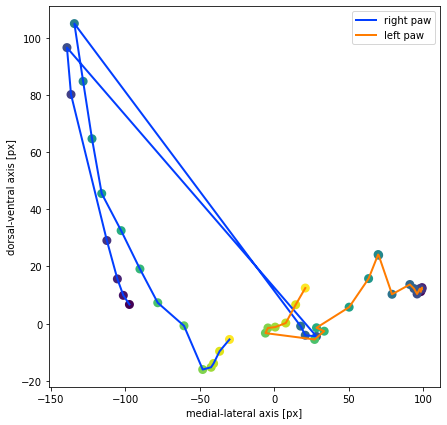

In [332]:
trace_type = 'single'
a = 'a11'
animal_df = grooming_traces_df.loc[
    (grooming_traces_df['animal_name'] == a) &
    (grooming_traces_df['trace_type'] == 'single')
]

animal_df['t_ms'] = animal_df['t'] * (1/619) * 1000

# get the rows from just the number of files
files_to_use = animal_df['file_name'].unique()[[5]]
animal_df = animal_df.loc[animal_df.file_name.isin(files_to_use)]

colors = sns.color_palette('bright')
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

    

means = animal_df.groupby(['t', 'hand']).mean().reset_index()


ax.plot(
    means.loc[means['hand'] == 'right']['x'],
    means.loc[means['hand'] == 'right']['y'],
    color=colors[0],
    alpha=1,
    linewidth=2,
    label='right paw'
)

ax.scatter(
    means.loc[means['hand'] == 'right']['x'],
    means.loc[means['hand'] == 'right']['y'],
    c=np.arange(len(means.loc[means['hand'] == 'left']['x'])),
    alpha=1,
    linewidth=3,
)



ax.plot(
    means.loc[means['hand'] == 'left']['x'],
    means.loc[means['hand'] == 'left']['y'],
    color=colors[1],
    alpha=1,
    linewidth=2,
    label='left paw'
)

ax.scatter(
    means.loc[means['hand'] == 'left']['x'],
    means.loc[means['hand'] == 'left']['y'],
    c=np.arange(len(means.loc[means['hand'] == 'left']['x'])),
    alpha=1,
    linewidth=3,
)





ax.set_xlabel('medial-lateral axis [px]')
ax.set_ylabel('dorsal-ventral axis [px]')


ax.legend()

if is_mirrored:
    mirror_name = 'mirrored'
else:
    mirror_name = 'not_mirrored'

if reversed_time:
    ax.invert_xaxis()
    time_name = 'reversed_time'
else:
    time_name = 'not_reversed_time'

im_file_base = f'grooming_trace_means_2d_{a}_{n_files}_trials_{mirror_name}_{time_name}'


fig.savefig(im_file_base + '.pdf', bbox_inches='tight')
fig.savefig(im_file_base + '.png',dpi=300, bbox_inches='tight')
